# A longitudinal single-cell atlas of radiotherapy response in Breast cancer

## 0 raw data

### 0.1 cellranger

In [1]:
# cellranger.sh

### 0.2 STAR

In [2]:
# star.sh

### 0.3 velocyto

In [3]:
# velocyto.sh

### 0.4 cellbender

will retain more cells than cellranger default filter matrix, might be useless, later validate it in UMAP

In [4]:
# cellbender.sh

### 0.5 SoupX
return same index but corrected matrix compared with filter_feature_bc_matrix

In [5]:
# soupX.R

### 0.6 scDbiFinder

In [6]:
# scDbiFinder_createobj.R

## 1 Processed data

In [19]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import os

In [13]:
adata = sc.read_h5ad("/home/zhepan/Project/MultiOmics/data/snRNA/Object/summary/Tcell/tcell_count.h5ad")

In [7]:
bar = pd.read_csv("/home/zhepan/Project/MultiOmics/code/VIFbarcodecorrect.csv", sep=",", index_col=0)

In [9]:
adata.obs= adata.obs.join(bar)

In [11]:
adata.obs_names = adata.obs['cor_bar']

In [ ]:
adata.write_h5ad("/home/zhepan/Project/MultiOmics/data/snRNA/Object/summary/Immune/tcell_count.h5ad")

In [26]:
sc.set_figure_params(dpi=120, dpi_save=300, vector_friendly=False, figsize=(4,4))
sc.settings.verbosity = 1
sc.logging.print_header()

%matplotlib inline 

scanpy==1.9.6 anndata==0.10.3 umap==0.5.5 numpy==1.24.2 scipy==1.11.4 pandas==2.1.3 scikit-learn==1.1.3 statsmodels==0.14.0 igraph==0.10.4 pynndescent==0.5.11


### 1.1 Load data

In [25]:
workdir = '/home/zhepan/Project/MultiOmics/data/snRNA/Object/'
sample_list = ['P1013S2','P1015S2','P1018S1']
resdir = '/home/zhepan/Project/MultiOmics/data/snRNA/Object/summary'
filtertype = 'cellranger'

In [27]:
#adata = sc.read_h5ad(adatapath)
adatas = [sc.read_h5ad(workdir+'/'+sample+'/raw/'+filtertype+'_doublet.h5ad') for sample in sample_list]

In [28]:
for index, adata in enumerate(adatas):
    adatas[index].obs_names = [obs_name[0:16] for obs_name in adatas[index].obs_names]

In [29]:
adata =adatas[0].concatenate(adatas[1:], join = 'outer')

/tmp/ipykernel_1081071/1621878994.py:1: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata =adatas[0].concatenate(adatas[1:], join = 'outer')


In [30]:
adata

AnnData object with n_obs × n_vars = 49814 × 28938
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'PatientID', 'NeoChemoRes', 'NeoRadRes', 'SampleID', 'SampleTimepoint', 'SampleMethod', 'SampleDate', 'Kit', 'scDblFinder.score', 'scDblFinder.class', 'percent_mt', 'percent_hb', 'S.Score', 'G2M.Score', 'Phase', 'batch'
    var: 'name-0', 'name-1', 'name-2'

In [31]:
mt_gene = adata.var_names[adata.var_names.str.startswith('MT-')]
hb_gene = adata.var_names[adata.var_names.str.contains('^HB[^P]')]
rp_gene = adata.var_names[adata.var_names.str.startswith('RPS','RPL')]

In [33]:
remove_gene = np.concatenate([mt_gene,hb_gene,rp_gene], axis = None)
remove_gene

array(['MT-ATP6', 'MT-ATP8', 'MT-CO1', 'MT-CO2', 'MT-CO3', 'MT-CYB',
       'MT-ND1', 'MT-ND2', 'MT-ND3', 'MT-ND4', 'MT-ND4L', 'MT-ND5',
       'MT-ND6', 'HBA1', 'HBA2', 'HBB', 'HBD', 'HBEGF', 'HBG1', 'HBG2',
       'HBM', 'HBQ1', 'HBS1L', 'HBZ', 'RPS10', 'RPS10-NUDT3', 'RPS11',
       'RPS12', 'RPS13', 'RPS14', 'RPS15', 'RPS15A', 'RPS16', 'RPS17',
       'RPS18', 'RPS19', 'RPS19BP1', 'RPS2', 'RPS20', 'RPS21', 'RPS23',
       'RPS24', 'RPS25', 'RPS26', 'RPS27', 'RPS27A', 'RPS27L', 'RPS28',
       'RPS29', 'RPS3', 'RPS3A', 'RPS4X', 'RPS5', 'RPS6', 'RPS6KA1',
       'RPS6KA2', 'RPS6KA3', 'RPS6KA4', 'RPS6KA5', 'RPS6KA6', 'RPS6KB1',
       'RPS6KB2', 'RPS6KB2-AS1', 'RPS6KC1', 'RPS6KL1', 'RPS7', 'RPS8',
       'RPS9', 'RPSA'], dtype=object)

In [34]:
adata = adata[:,adata.var_names.isin(remove_gene) == False]

In [35]:
adata

View of AnnData object with n_obs × n_vars = 49814 × 28869
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'PatientID', 'NeoChemoRes', 'NeoRadRes', 'SampleID', 'SampleTimepoint', 'SampleMethod', 'SampleDate', 'Kit', 'scDblFinder.score', 'scDblFinder.class', 'percent_mt', 'percent_hb', 'S.Score', 'G2M.Score', 'Phase', 'batch'
    var: 'name-0', 'name-1', 'name-2'

In [36]:
adata.obs['SampleID'].value_counts()

SampleID
P1018S1    26754
P1013S2    13390
P1015S2     9670
Name: count, dtype: int64

### 1.2 Preprocessing

/home/zhepan/miniconda3/envs/scRNA/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/zhepan/miniconda3/envs/scRNA/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/zhepan/miniconda3/envs/scRNA/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/zhepan/miniconda3/envs/scRNA/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categoric

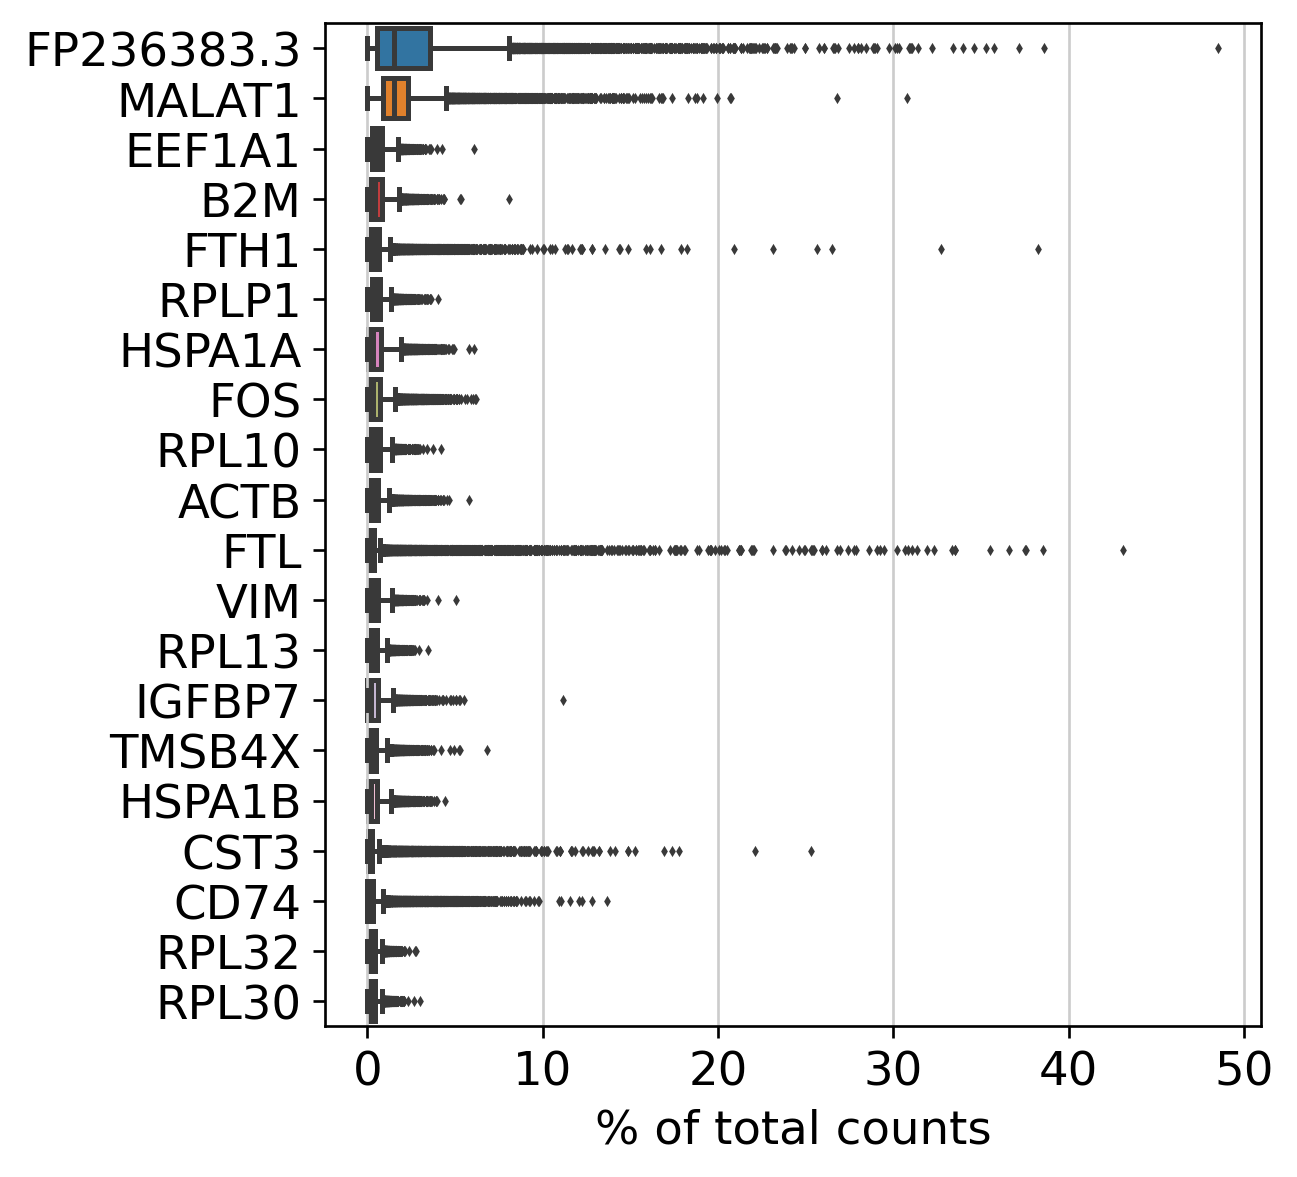

In [37]:
sc.pl.highest_expr_genes(adata, n_top=20)

In [38]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

/home/zhepan/miniconda3/envs/scRNA/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/zhepan/miniconda3/envs/scRNA/lib/python3.9/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/home/zhepan/miniconda3/envs/scRNA/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/zhepan/miniconda3/envs/scRNA/lib/python3.9/site-packages/seaborn/categorical

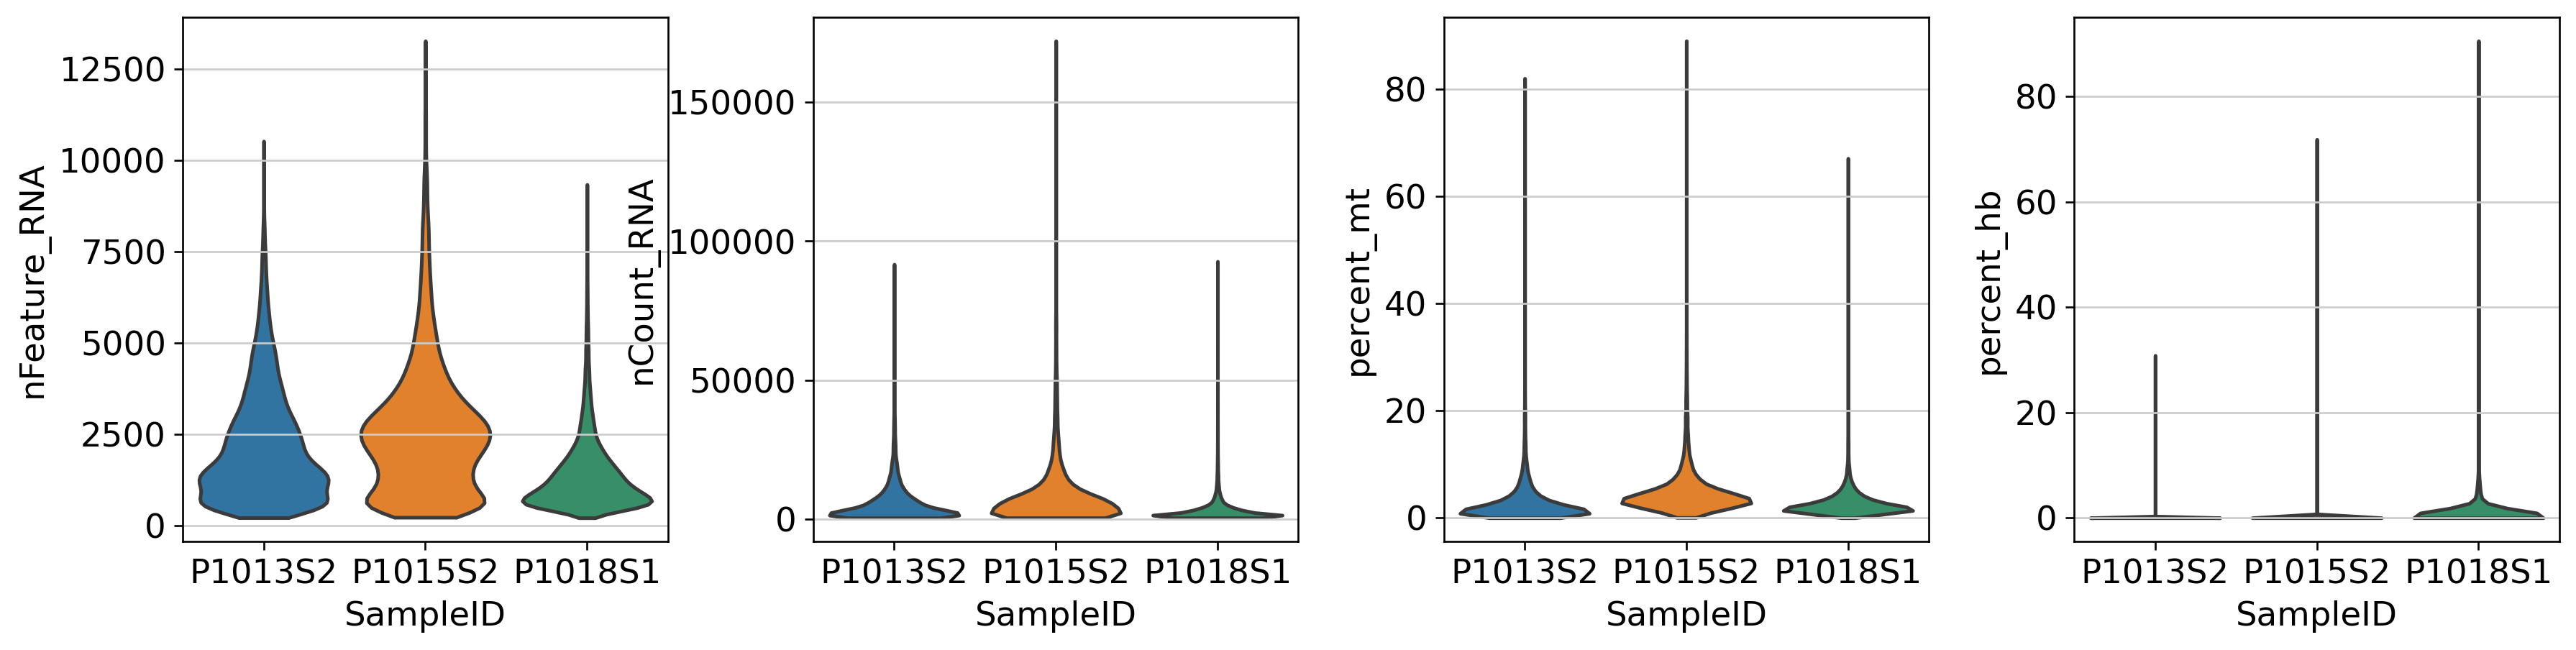

In [39]:
sc.pl.violin(adata, ['nFeature_RNA', 'nCount_RNA', 'percent_mt','percent_hb'],groupby='SampleID',
             jitter=0.4, multi_panel=True,stripplot=False)

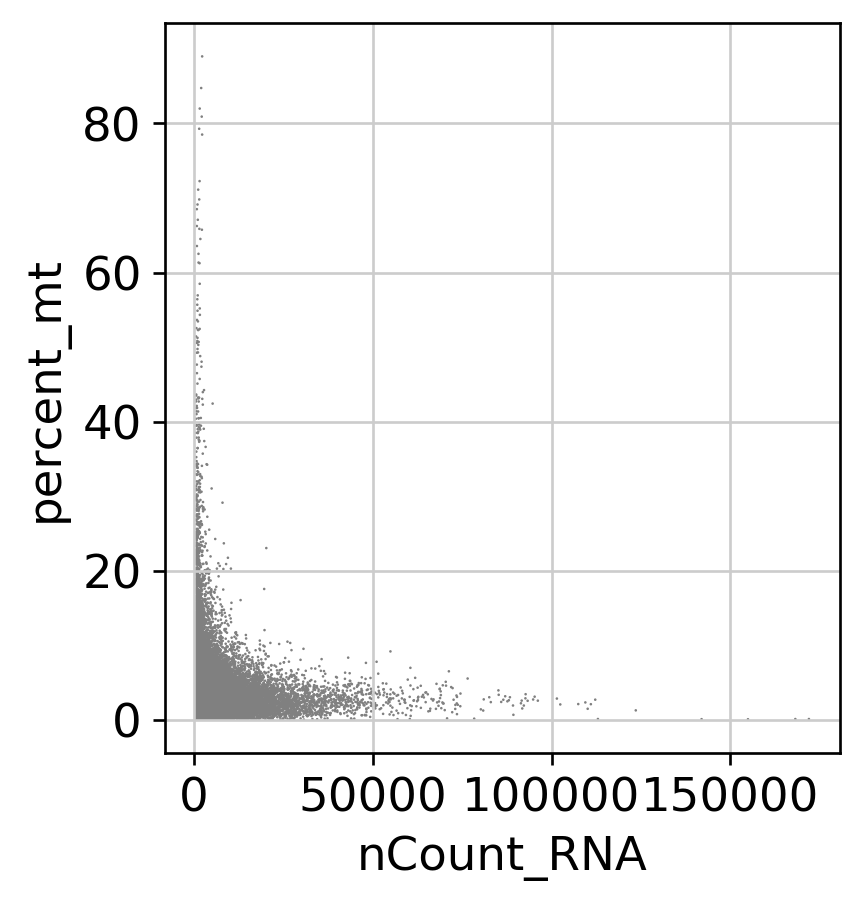

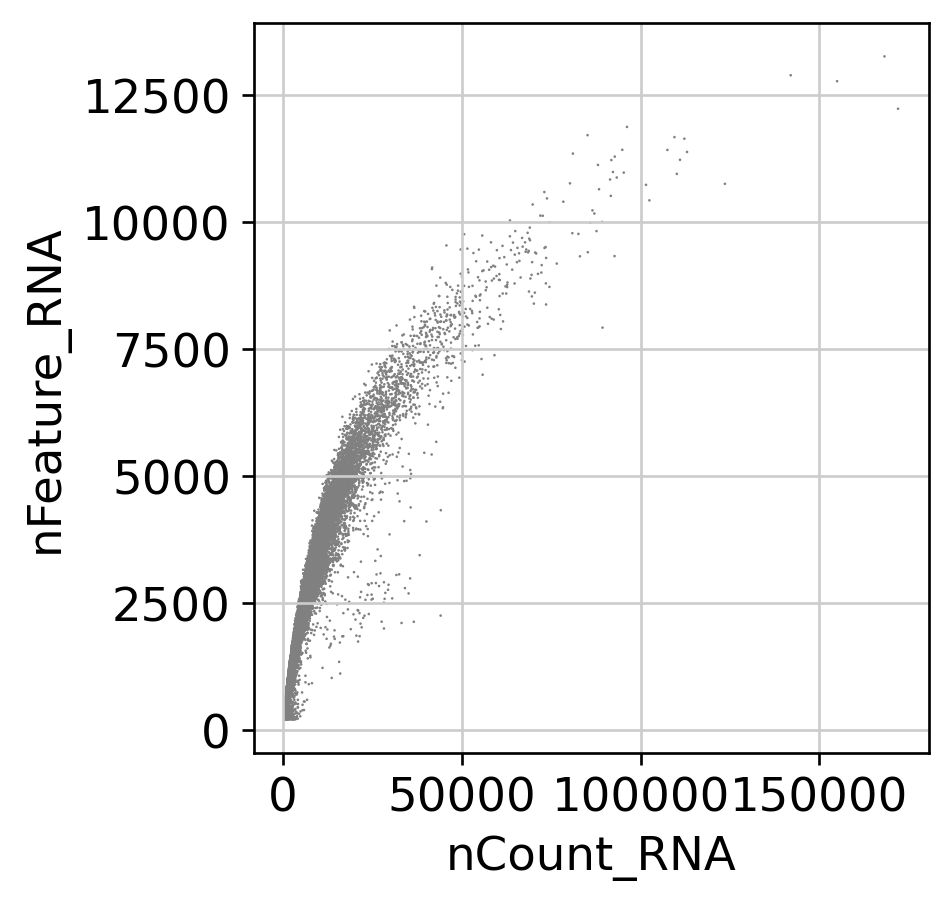

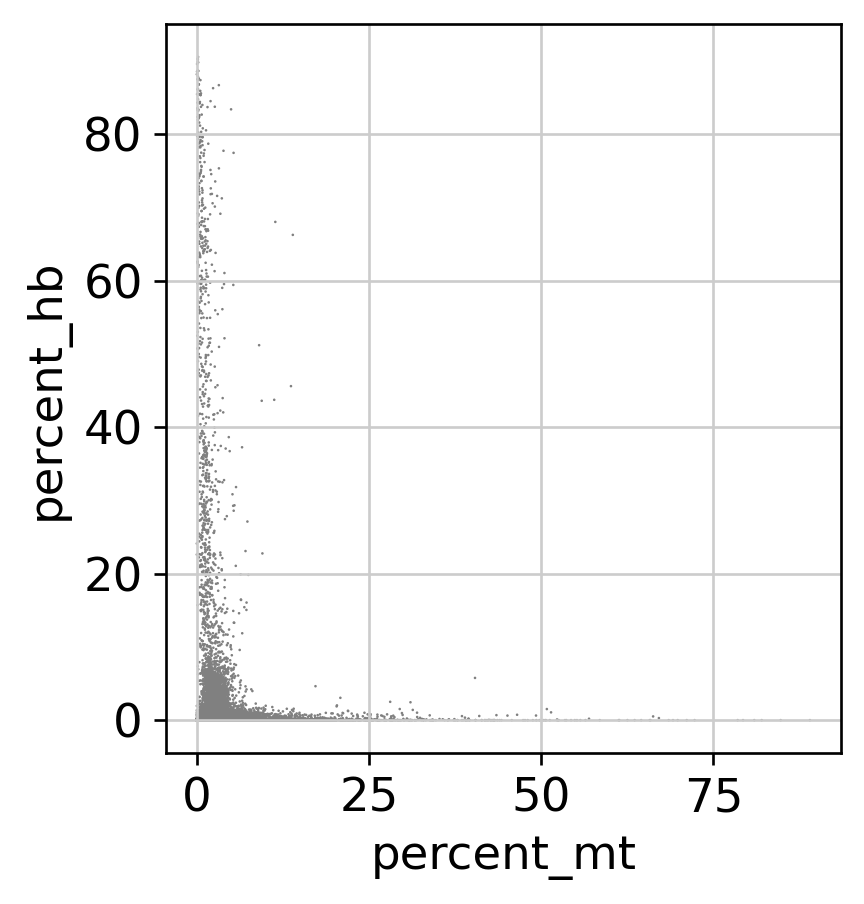

In [40]:
sc.pl.scatter(adata, x='nCount_RNA', y='percent_mt')
sc.pl.scatter(adata, x='nCount_RNA', y='nFeature_RNA')
sc.pl.scatter(adata, x='percent_mt', y='percent_hb')

In [41]:
adata = adata[adata.obs.nFeature_RNA < 5000, :]
adata = adata[adata.obs.nCount_RNA < 20000, :]
adata = adata[adata.obs.nCount_RNA > 500,:]
adata = adata[adata.obs.percent_mt < 20, :]
adata = adata[adata.obs.percent_hb < 0.2, :]
adata = adata[adata.obs['scDblFinder.class'] == 'singlet', :]

In [42]:
adata

View of AnnData object with n_obs × n_vars = 27589 × 28868
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'PatientID', 'NeoChemoRes', 'NeoRadRes', 'SampleID', 'SampleTimepoint', 'SampleMethod', 'SampleDate', 'Kit', 'scDblFinder.score', 'scDblFinder.class', 'percent_mt', 'percent_hb', 'S.Score', 'G2M.Score', 'Phase', 'batch', 'n_genes'
    var: 'name-0', 'name-1', 'name-2', 'n_cells'
    uns: 'SampleID_colors'

/home/zhepan/miniconda3/envs/scRNA/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/zhepan/miniconda3/envs/scRNA/lib/python3.9/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/home/zhepan/miniconda3/envs/scRNA/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/zhepan/miniconda3/envs/scRNA/lib/python3.9/site-packages/seaborn/categorical

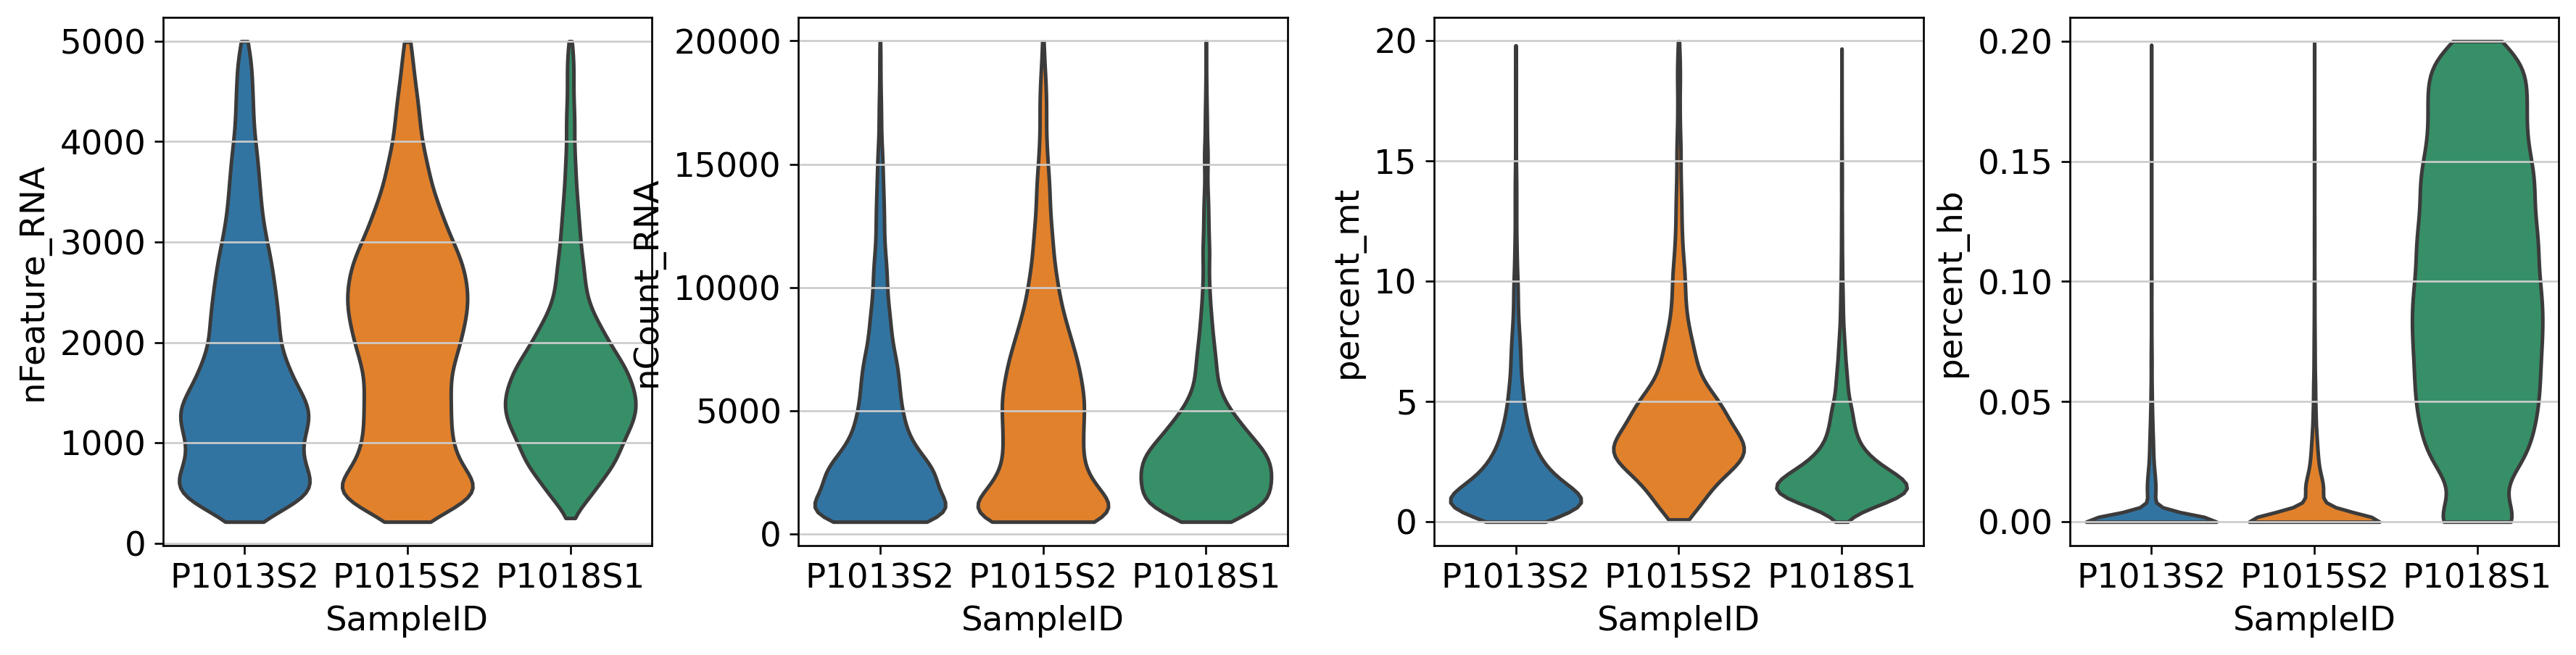

In [59]:
sc.pl.violin(adata, ['nFeature_RNA', 'nCount_RNA', 'percent_mt','percent_hb'],groupby='SampleID',
             jitter=0.4, multi_panel=True,stripplot=False)

In [43]:
adata.obs.groupby('SampleID')['percent_hb'].describe()

/tmp/ipykernel_1081071/3355869019.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata.obs.groupby('SampleID')['percent_hb'].describe()


count      mean       std  min       25%       50%       75%  \
SampleID                                                                   
P1013S2   11001.0  0.006874  0.019635  0.0  0.000000  0.000000  0.000000   
P1015S2    7497.0  0.008959  0.022160  0.0  0.000000  0.000000  0.010143   
P1018S1    9091.0  0.098568  0.055760  0.0  0.053586  0.096993  0.144300   

               max  
SampleID            
P1013S2   0.198413  
P1015S2   0.199203  
P1018S1   0.199920

In [18]:
adata.write_h5ad(resdir+'/'+filtertype+'_qc.h5ad')

/home/zhepan/miniconda3/envs/scRNA/lib/python3.9/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  df[key] = c
/home/zhepan/miniconda3/envs/scRNA/lib/python3.9/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  df[key] = c
/home/zhepan/miniconda3/envs/scRNA/lib/python3.9/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  df[key] = c
/home/zhepan/miniconda3/envs/scRNA/lib/python3.9/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  df[key] = c
/home/zhepan/miniconda3/envs/scRNA/lib/python3.9/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.var` of view

In [44]:
adata.layers['count'] = adata.X.copy()

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata

/tmp/ipykernel_1081071/2366724831.py:1: ImplicitModificationWarning: Setting element `.layers['count']` of view, initializing view as actual.
  adata.layers['count'] = adata.X.copy()


In [45]:
sc.pp.highly_variable_genes(
    adata,layer = 'count',
    flavor="seurat_v3",
    n_top_genes=3000,
    batch_key="SampleID",
    subset=True,
)
#sc.pl.highly_variable_genes(adata)

In [46]:
#sc.pp.regress_out(adata, ['S_score', 'G2M_score'])
sc.pp.scale(adata)

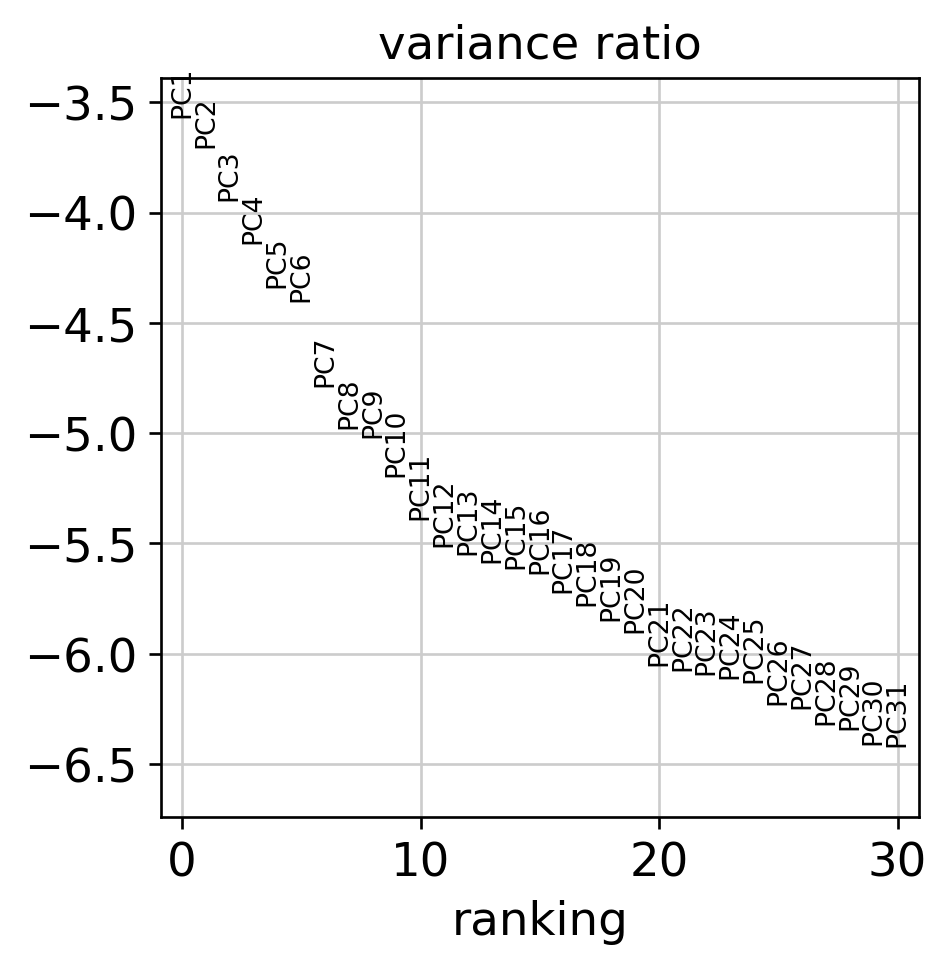

In [47]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True)

### 1.3 Clustering

In [48]:
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=40)
sc.tl.umap(adata,min_dist=0.2)

/home/zhepan/miniconda3/envs/scRNA/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/zhepan/miniconda3/envs/scRNA/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


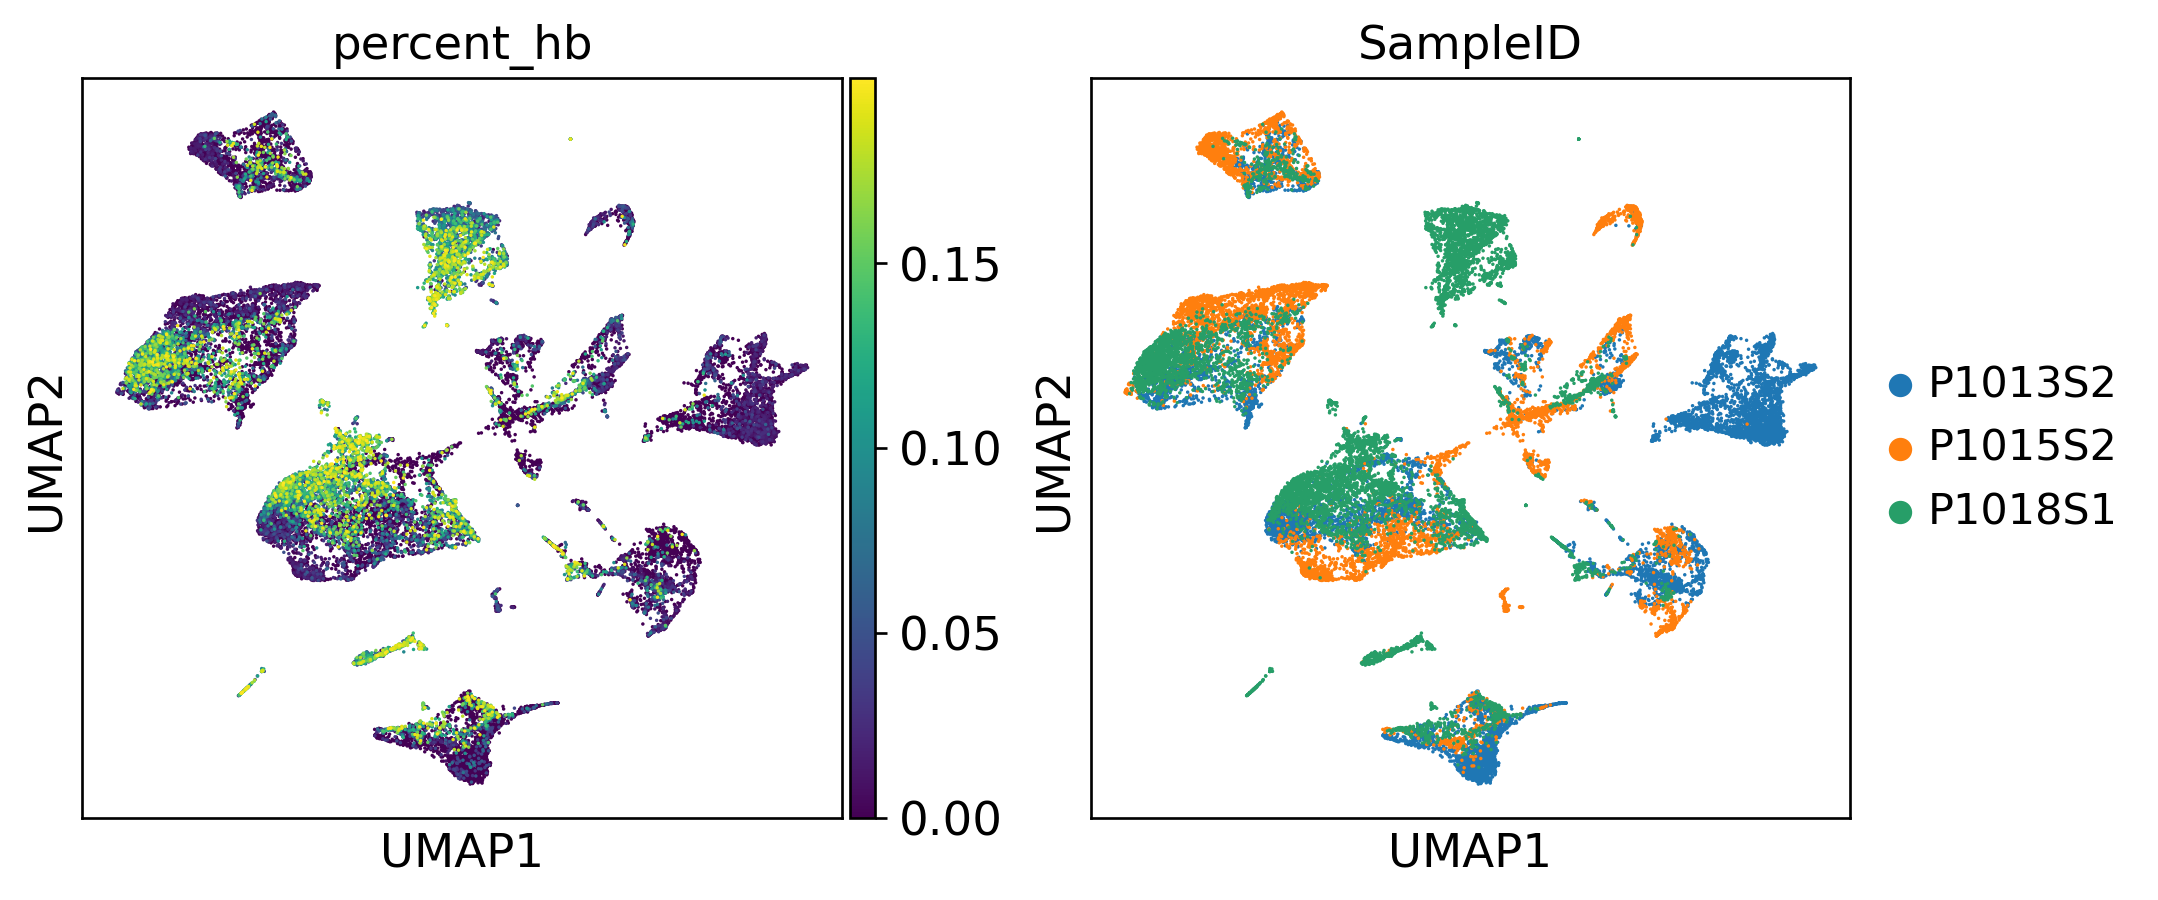

In [49]:
sc.pl.umap(adata,color = ['percent_hb','SampleID'])

In [68]:
sc.tl.leiden(adata, resolution=0.1,key_added='leiden_0.1')
#sc.tl.leiden(adata, resolution=0.2,key_added='leiden_0.2')

In [ ]:
adata.obs["leiden_0.1"].value_counts()

In [ ]:
pd.crosstab(adata.obs['leiden_0.1'], adata.obs['SampleID'])

/home/zhepan/miniconda3/envs/scRNA/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/zhepan/miniconda3/envs/scRNA/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/zhepan/miniconda3/envs/scRNA/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.ma

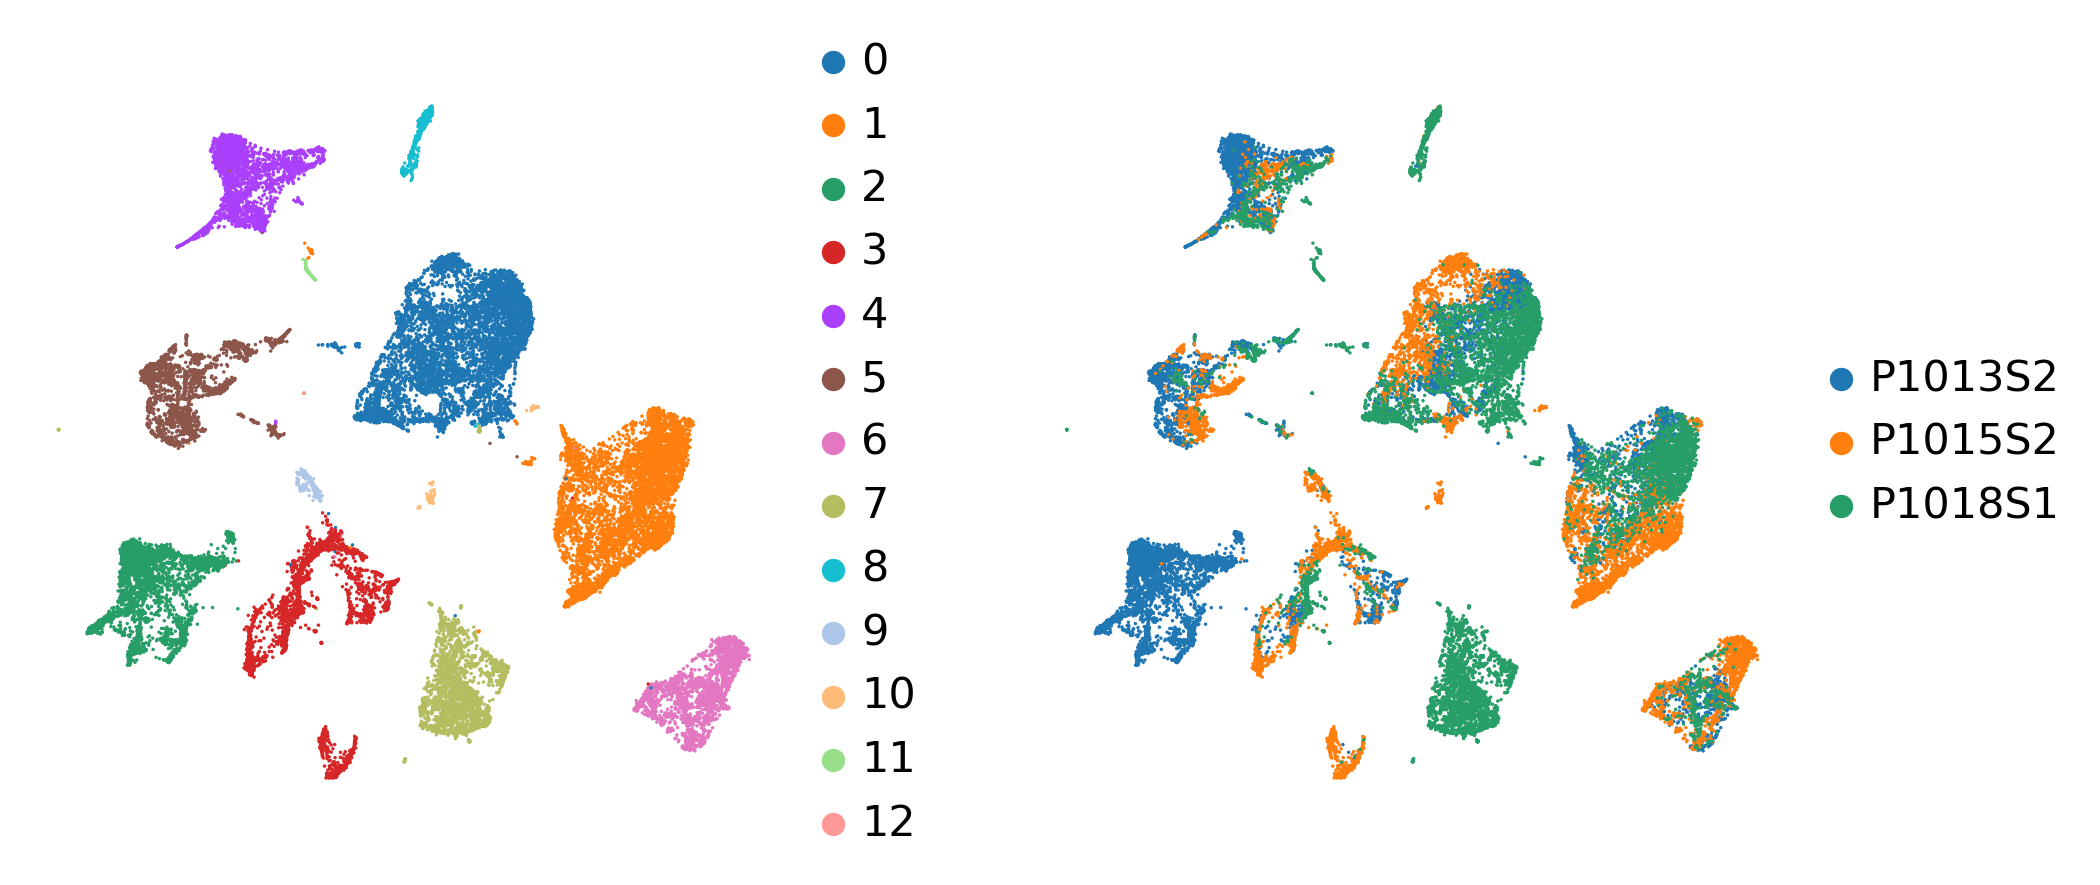

In [70]:
sc.pl.umap(adata, color=['leiden_0.1','SampleID'], title=['',''], frameon=False)

In [ ]:
adata.write_h5ad(resdir+'/'+filtertype+'_cluster.h5ad')

#### 1.3.1 visualization

In [ ]:
# visualization.R

In [8]:
canonical_markers = {
    'Adipocyte' : ['ADIPOQ', 'FABP4', 'LEP'],
    'Endothelial' : ['VWF', 'CDH5', 'CLEC14A', 'CLDN5', 'ADGRL4'],
    'Epithelial' : ['EPCAM', 'KRT19', 'KRT7', 'KRT8'],
    'Fibroblast' : ['COL1A1', 'COL1A2', 'COL3A1', 'LUM'],
    'Neutrophil' : ['AZU1', 'CTSG', 'ELANE', 'MPO'],
    'Immune' : ['PTPRC'],
    'Effect' : ['PDCD1','CD274','CXCL13','TIGIT','GZMK','IL7R','LEF1','MKI67'],
    'T_cell' : ['CD2', 'CD3D', 'CD3E', 'CD4', 'CD8A'],
    'B_cell' : ['MS4A1', 'CD79A', 'CD79B'],
    'NK_cell' : ['NKG7', 'KLRD1', 'GZMB', 'KLRF1',"GNLY","TYROBP",'FCGR3A'],
    'Macrophage' : ['TREM2', 'FOLR2', 'SPP1', 'CD14', 'CD163'],
    'Mast' : ['CPA3', 'MS4A2', 'TPSB2'],
    'Monocyte' : ['CCR2', 'CSF1R',"FCN1", "CD14"],
    'Dendritic' : ['CCR7', 'CD86', 'CLEC10A'],
    "cDC1": ["CLEC9A", "CADM1","CST3","COTL1","LYZ"],
    "Normoblast": ["SLC4A1", "SLC25A37", "HBB", "HBA2", "HBA1", "TFRC"],
    "Erythroblast": ["MKI67", "HBA1", "HBB"],
    "ILC": ["ID2", "PLCG2", "GNLY", "SYNE1"],
    "Lymph prog": ["VPREB1","MME","EBF1","SSBP2","BACH2","CD79B",
        "IGHM","PAX5","PRKCE","DNTT","IGLL1",],
    "Naive CD20+ B": ["MS4A1", "IL4R", "IGHD", "FCRL1", "IGHM"],
    "B1 B": ["MS4A1","SSPN","ITGB1","EPHA4","COL4A4",
        "PRDM1","IRF4", "CD38","XBP1","PAX5","BCL11A",
        "BLK", "IGHD","IGHM","ZNF215",
    ],  # Note IGHD and IGHM are negative markers
    "Transitional B": ["MME", "CD38", "CD24", "ACSM3", "MSI2"],
    "Plasma cells": ["MZB1", "HSP90B1", "FNDC3B", "PRDM1", "IGKC", "JCHAIN"],
    "Plasmablast": ["XBP1", "RF4", "PRDM1", "PAX5"],  # Note PAX5 is a negative marker
    "CD4+ T activated": ["CD4", "IL7R", "TRBC2", "ITGB1"],
    "CD4+ T naive": ["CD4", "IL7R", "TRBC2", "CCR7"],
    "CD8+ T": ["CD8A", "CD8B", "GZMK", "GZMA", "CCL5", "GZMB", "GZMH", "GZMA"],
    "T activation": ["CD69", "CD38"],  # CD69 much better marker!
    "T naive": ["LEF1", "CCR7", "TCF7"],
    "pDC": ["GZMB", "IL3RA", "COBLL1", "TCF4"],
    "G/M prog": ["MPO", "BCL2", "KCNQ5", "CSF3R"],
    "HSC": ["NRIP1", "MECOM", "PROM1", "NKAIN2", "CD34"],
    "MK/E prog": ["ZNF385D","ITGA2B","RYR3","PLCB1", ],  # Note PLCB1 is a negative marker

}


In [11]:
marker_genes_in_data = dict()
for ct, markers in canonical_markers.items():
    markers_found = list()
    for marker in markers:
        if marker in readata.var.index:
            markers_found.append(marker)
    marker_genes_in_data[ct] = markers_found


In [ ]:
sc.pl.umap(adata, color=marker_genes_in_data['Fibroblast'], frameon=False, ncols=6, vmax='p99', use_raw=True)
sc.pl.umap(adata, color=marker_genes_in_data['Macrophage'], frameon=False, ncols=6, vmax='p99', use_raw=True)
sc.pl.umap(adata, color=marker_genes_in_data['T_cell'], frameon=False, ncols=6, vmax='p99', use_raw=True)
sc.pl.umap(adata, color=marker_genes_in_data['Epithelial'], frameon=False, ncols=6, vmax='p99', use_raw=True)

In [66]:
celltype = ['Endothelial','Epithelial','T_cell','B_cell','NK_cell','Macrophage','Mast','Monocyte','Dendritic','Normoblast','Fibroblast']
celltype_marker = {key: marker_genes_in_data[key] for key in celltype}

In [ ]:
sc.pl.dotplot(adata, celltype_marker, 'leiden_0.1',dendrogram=False, swap_axes=False)

In [ ]:
sc.pl.stacked_violin(adata, celltype_marker, groupby='leiden_0.1',
                     swap_axes=False, dendrogram=False,
                     row_palette='Paired')

### 1.4 celltype annotation

#### 1.4.1 manually

In [ ]:
adata = sc.read_h5ad(os.path.join(resdir,'cluster.h5ad'))

In [ ]:
cl_annotation={
    "0": "Endothelial",
    "1": "Epithelial",
    "2": "Stromal",
    "3": "T cell",
    "4": "Macro/Mono",
    "5": "Fibroblast",
    "6": "Epithelial",
    "7": "Mast",
    "8": "B cell",
    "9": "undefined",
}

In [ ]:
adata.obs["manual_celltype_annotation"] = adata.obs['harmony_leiden_0.1'].map(cl_annotation)

In [ ]:
pd.crosstab(adata.obs['manual_celltype_annotation'],adata.obs['harmony_leiden_0.1'])

In [ ]:
adata.obs['manual_celltype_annotation'].to_csv(os.path.join(resdir,'annotation','manual_annotation.csv'))

#### 1.4.2 celltypist

In [13]:
import celltypist

1.4.2.1 model train

In [ ]:
## celltypist.ipynb

##### 1.4.2.2 predict

In [6]:
final_adata = sc.read_h5ad(os.path.join(resdir,'cellranger_filter.h5ad'))

In [15]:
final_adata

AnnData object with n_obs × n_vars = 26549 × 3000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'PatientID', 'NeoChemoRes', 'NeoRadRes', 'SampleID', 'SampleTimepoint', 'SampleMethod', 'SampleDate', 'Kit', 'scDblFinder.score', 'scDblFinder.class', 'percent_mt', 'percent_hb', 'S.Score', 'G2M.Score', 'Phase', 'batch', 're_leiden_0.2', 're_leiden_0.4', 're_leiden_0.6', 'manual_celltype_annotation'
    var: 'name-0', 'name-1', 'name-2', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches', 'mean', 'std'
    uns: 'SampleID_colors', 'hvg', 'leiden', 'log1p', 'manual_celltype_annotation_colors', 'neighbors', 'pca', 're_leiden_0.2_colors', 're_leiden_0.4_colors', 're_leiden_0.6_colors', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    layers: 'count'
    obsp: 'connectivities', 'distances'

In [19]:
pd.crosstab(final_adata.obs['manual_celltype_annotation'],final_adata.obs['re_leiden_0.2'])

re_leiden_0.2                  0     1     2     3     4     5     6     7  \
manual_celltype_annotation                                                   
B cell                         0     0     0     0     0     0     0     0   
Endothelial                 6396     0     0     0     0     0     0     0   
Epithelial                     0     0  3357  2694     0     0     0  1166   
Fibroblast                     0     0     0     0     0  2159     0     0   
Macro/Mono                     0     0     0     0     0     0  1957     0   
Mast                           0     0     0     0     0     0     0     0   
Stromal                        0  4602     0     0     0     0     0     0   
T cell                         0     0     0     0  2515     0     0     0   

re_leiden_0.2                 8    9   10  
manual_celltype_annotation                 
B cell                        0    0  291  
Endothelial                   0    0    0  
Epithelial                    0    0    0  
Fibroblast                    0    0    0  
Macro/Mono                    0    0    0  
Mast                          0  486    0  
Stromal                     926    0    0  
T cell                        0    0    0

In [21]:
adata_topre = adata[adata.obs_names.isin(final_adata.obs_names),:]

In [22]:
adata_topre.write_h5ad(resdir+'/cellranger_filter_count.h5ad')

In [10]:
adata_topre

View of AnnData object with n_obs × n_vars = 26549 × 28938
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'PatientID', 'NeoChemoRes', 'NeoRadRes', 'SampleID', 'SampleTimepoint', 'SampleMethod', 'SampleDate', 'Kit', 'scDblFinder.score', 'scDblFinder.class', 'percent_mt', 'percent_hb', 'S.Score', 'G2M.Score', 'Phase', 'batch'
    var: 'name-0', 'name-1', 'name-2'

In [12]:
sc.pp.normalize_total(adata_topre, target_sum=1e4)
sc.pp.log1p(adata_topre)

/home/zhepan/miniconda3/envs/scRNA/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [14]:
%%time
# CellTypist prediction with over-clustering and majority-voting.
predictions_BCatlas_major = celltypist.annotate(adata_topre, model = '/home/zhepan/Reference/celltypist/celltype_major_from_BCatlas.pkl', majority_voting = True)
predictions_BCatlas_minor = celltypist.annotate(adata_topre, model = '/home/zhepan/Reference/celltypist/celltype_minor_from_BCatlas.pkl', majority_voting = True)
predictions_BCatlas_subset = celltypist.annotate(adata_topre, model = '/home/zhepan/Reference/celltypist/celltype_subset_from_BCatlas.pkl', majority_voting = True)
predictions_HBCA_broad_cell_type = celltypist.annotate(adata_topre, model = '/home/zhepan/Reference/celltypist/broad_cell_type_from_HBCA.pkl', majority_voting = True)
predictions_HBCA_cell_type = celltypist.annotate(adata_topre, model = '/home/zhepan/Reference/celltypist/cell_type_from_HBCA.pkl', majority_voting = True)
predictions_HBCA_author_cell_type = celltypist.annotate(adata_topre, model = '/home/zhepan/Reference/celltypist/author_cell_type_from_HBCA.pkl', majority_voting = True)
#predictions_HBCA_sn = celltypist.annotate(adata, model = '/home/zhepan/Reference/celltypist/broad_cell_type_from_HBCA_sn.pkl', majority_voting = True)

🔬 Input data has 26549 cells and 28938 genes
🔗 Matching reference genes in the model
🧬 2621 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 15
🗳️ Majority voting the predictions
✅ Majority voting done!
🔬 Input data has 26549 cells and 28938 genes
🔗 Matching reference genes in the model
🧬 2621 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 15
🗳️ Majority voting the predictions
✅ Majority voting done!
🔬 Input data has 26549 cells and 28938 genes
🔗 Matching reference genes in the model
🧬 2621 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the 

CPU times: user 3min 7s, sys: 1min 41s, total: 4min 49s
Wall time: 2min 49s


In [17]:
predictions_BCatlas_major.predicted_labels.to_csv(os.path.join(resdir, 'annotation/predictions_BCatlas_major.csv'))
predictions_BCatlas_minor.predicted_labels.to_csv(os.path.join(resdir, 'annotation/predictions_BCatlas_minor.csv'))
predictions_BCatlas_subset.predicted_labels.to_csv(os.path.join(resdir, 'annotation/predictions_BCatlas_subset.csv'))
predictions_HBCA_broad_cell_type.predicted_labels.to_csv(os.path.join(resdir, 'annotation/predictions_HBCA_broad_cell_type.csv'))
predictions_HBCA_cell_type.predicted_labels.to_csv(os.path.join(resdir, 'annotation/predictions_HBCA_cell_type.csv'))
predictions_HBCA_author_cell_type.predicted_labels.to_csv(os.path.join(resdir, 'annotation/predictions_HBCA_author_cell_type.csv'))

In [27]:
pd.crosstab(predictions_BCatlas_major.predicted_labels['predicted_labels'],
            final_adata.obs.manual_celltype_annotation)

manual_celltype_annotation  B cell  Endothelial  Epithelial  Fibroblast  \
predicted_labels                                                          
B-cells                         76            0           6           0   
CAFs                             3           14          55        2041   
Cancer Epithelial                2           16        4267           6   
Endothelial                     20         6295         136          39   
Myeloid                          6            8          37           2   
Normal Epithelial               17           23        2532          13   
PVL                             11           27          65          50   
Plasmablasts                   147            0           1           0   
T-cells                          9           13         118           8   

manual_celltype_annotation  Macro/Mono  Mast  Stromal  T cell  
predicted_labels                                               
B-cells                             10     0        1       0  
CAFs                                 3     9       34       1  
Cancer Epithelial                   12    12       13       3  
Endothelial                         16    49      107      26  
Myeloid                           1862     6        2       1  
Normal Epithelial                   12     1        4       1  
PVL                                 13    41     5362      13  
Plasmablasts                         0     0        0       0  
T-cells                             29   368        5    2470

#### 1.4.3 celltype annotation matrix generate

In [ ]:
# anno_info.R

In [ ]:
# use ref from zemin zhang pan-cancer data help to annotate immune cell subset

#### 1.4.4 InferCNV 

Identify tumor cell from epitheial cell

In [ ]:
# infercnv.R

### 1.5 Integration

#### 1.5.1 scVI

In [ ]:
# scANVI.ipynb

#### 1.5.2 Harmony

In [ ]:
# harmony.R

In [50]:
import scanpy.external as sce

In [51]:
adata

AnnData object with n_obs × n_vars = 27589 × 3000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'PatientID', 'NeoChemoRes', 'NeoRadRes', 'SampleID', 'SampleTimepoint', 'SampleMethod', 'SampleDate', 'Kit', 'scDblFinder.score', 'scDblFinder.class', 'percent_mt', 'percent_hb', 'S.Score', 'G2M.Score', 'Phase', 'batch', 'n_genes'
    var: 'name-0', 'name-1', 'name-2', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches', 'mean', 'std'
    uns: 'SampleID_colors', 'log1p', 'hvg', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'count'
    obsp: 'distances', 'connectivities'

In [54]:
sce.pp.harmony_integrate(adata, 'SampleID')

2023-12-12 01:30:27,041 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...


2023-12-12 01:30:45,665 - harmonypy - INFO - sklearn.KMeans initialization complete.
2023-12-12 01:30:45,972 - harmonypy - INFO - Iteration 1 of 10
2023-12-12 01:31:03,957 - harmonypy - INFO - Iteration 2 of 10
2023-12-12 01:31:22,021 - harmonypy - INFO - Iteration 3 of 10
2023-12-12 01:31:33,955 - harmonypy - INFO - Iteration 4 of 10
2023-12-12 01:31:56,604 - harmonypy - INFO - Iteration 5 of 10
2023-12-12 01:32:15,075 - harmonypy - INFO - Converged after 5 iterations


In [55]:
sc.pp.neighbors(adata, use_rep='X_pca_harmony',n_neighbors=15, n_pcs=40)
sc.tl.leiden(adata, resolution=0.1, key_added='harmony_leiden_0.1')
sc.tl.umap(adata,min_dist=0.2)

In [ ]:
adata

In [ ]:
pd.crosstab(adata.obs['harmony_leiden_0.1'], adata.obs['SampleID'])

In [ ]:
adata.obs['harmony_leiden_0.1'].value_counts()

/home/zhepan/miniconda3/envs/scRNA/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/zhepan/miniconda3/envs/scRNA/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/zhepan/miniconda3/envs/scRNA/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.ma

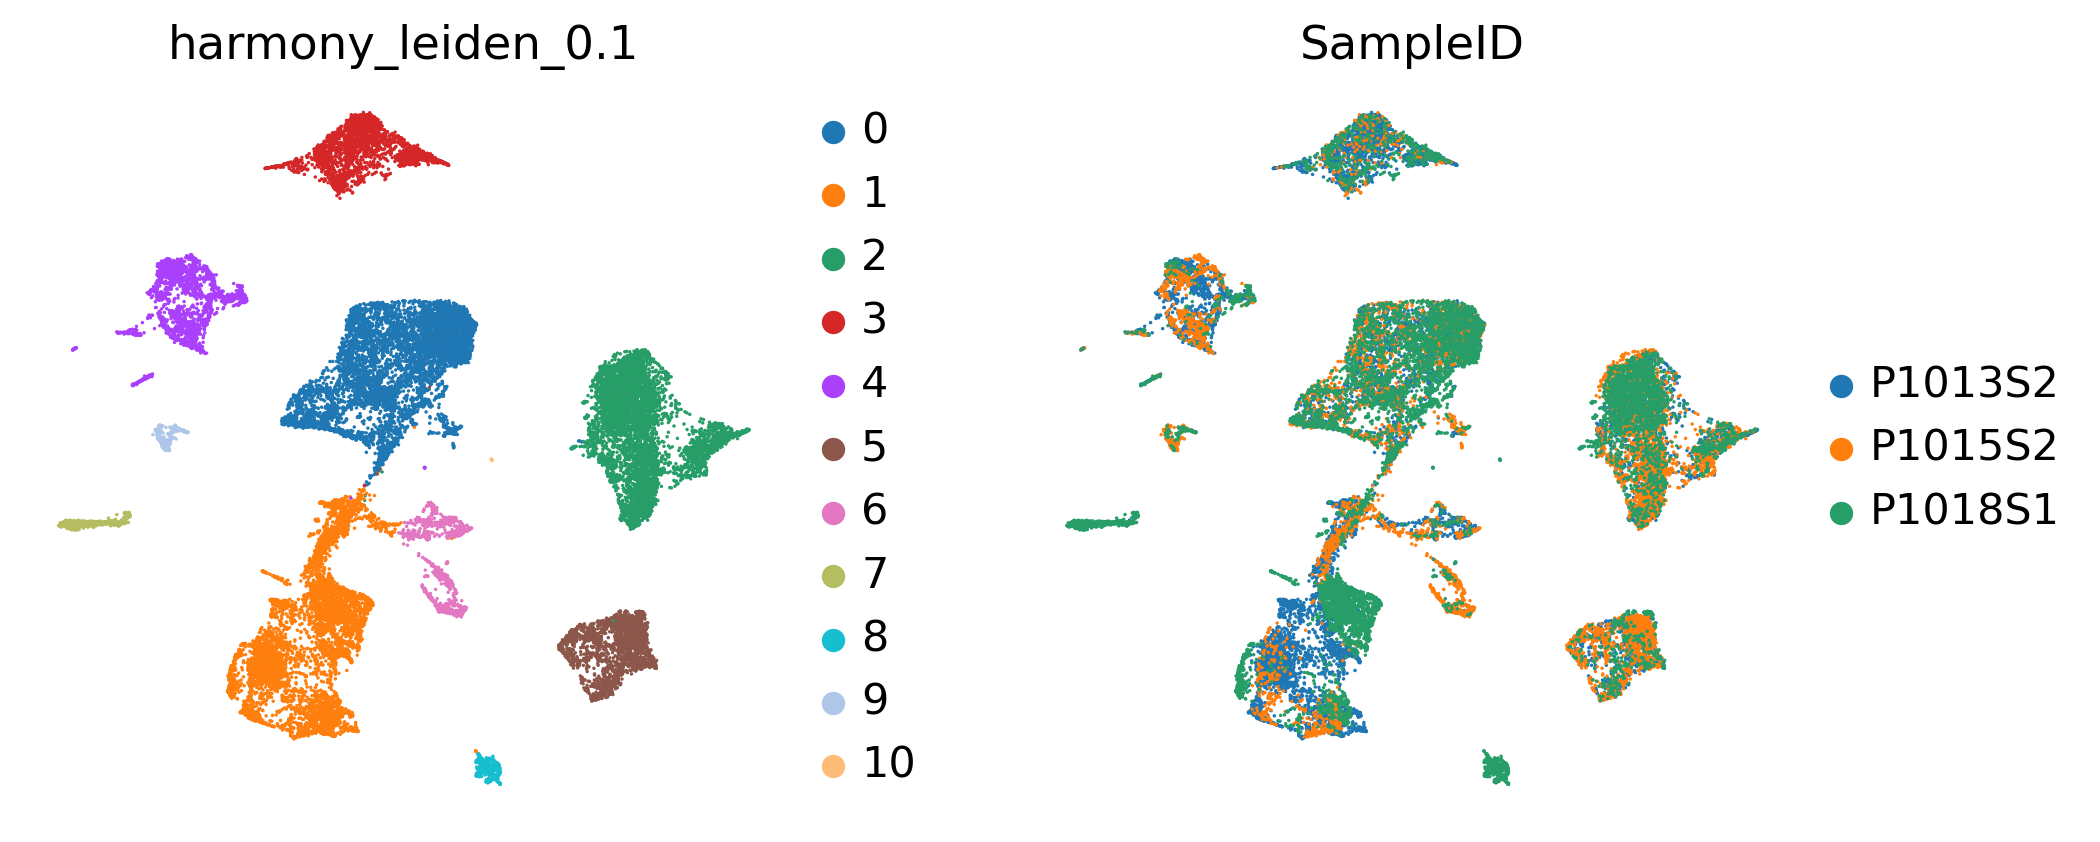

In [56]:
sc.pl.umap(adata, color=["harmony_leiden_0.1", "SampleID"], frameon=False, ncols=2)

In [31]:
for i in [0.2,0.4,0.8]:
    sc.tl.leiden(adata, resolution = i, key_added = ('harmony_leiden_'+str(i)))

/home/zhepan/miniconda3/envs/scRNA/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/zhepan/miniconda3/envs/scRNA/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/zhepan/miniconda3/envs/scRNA/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.ma

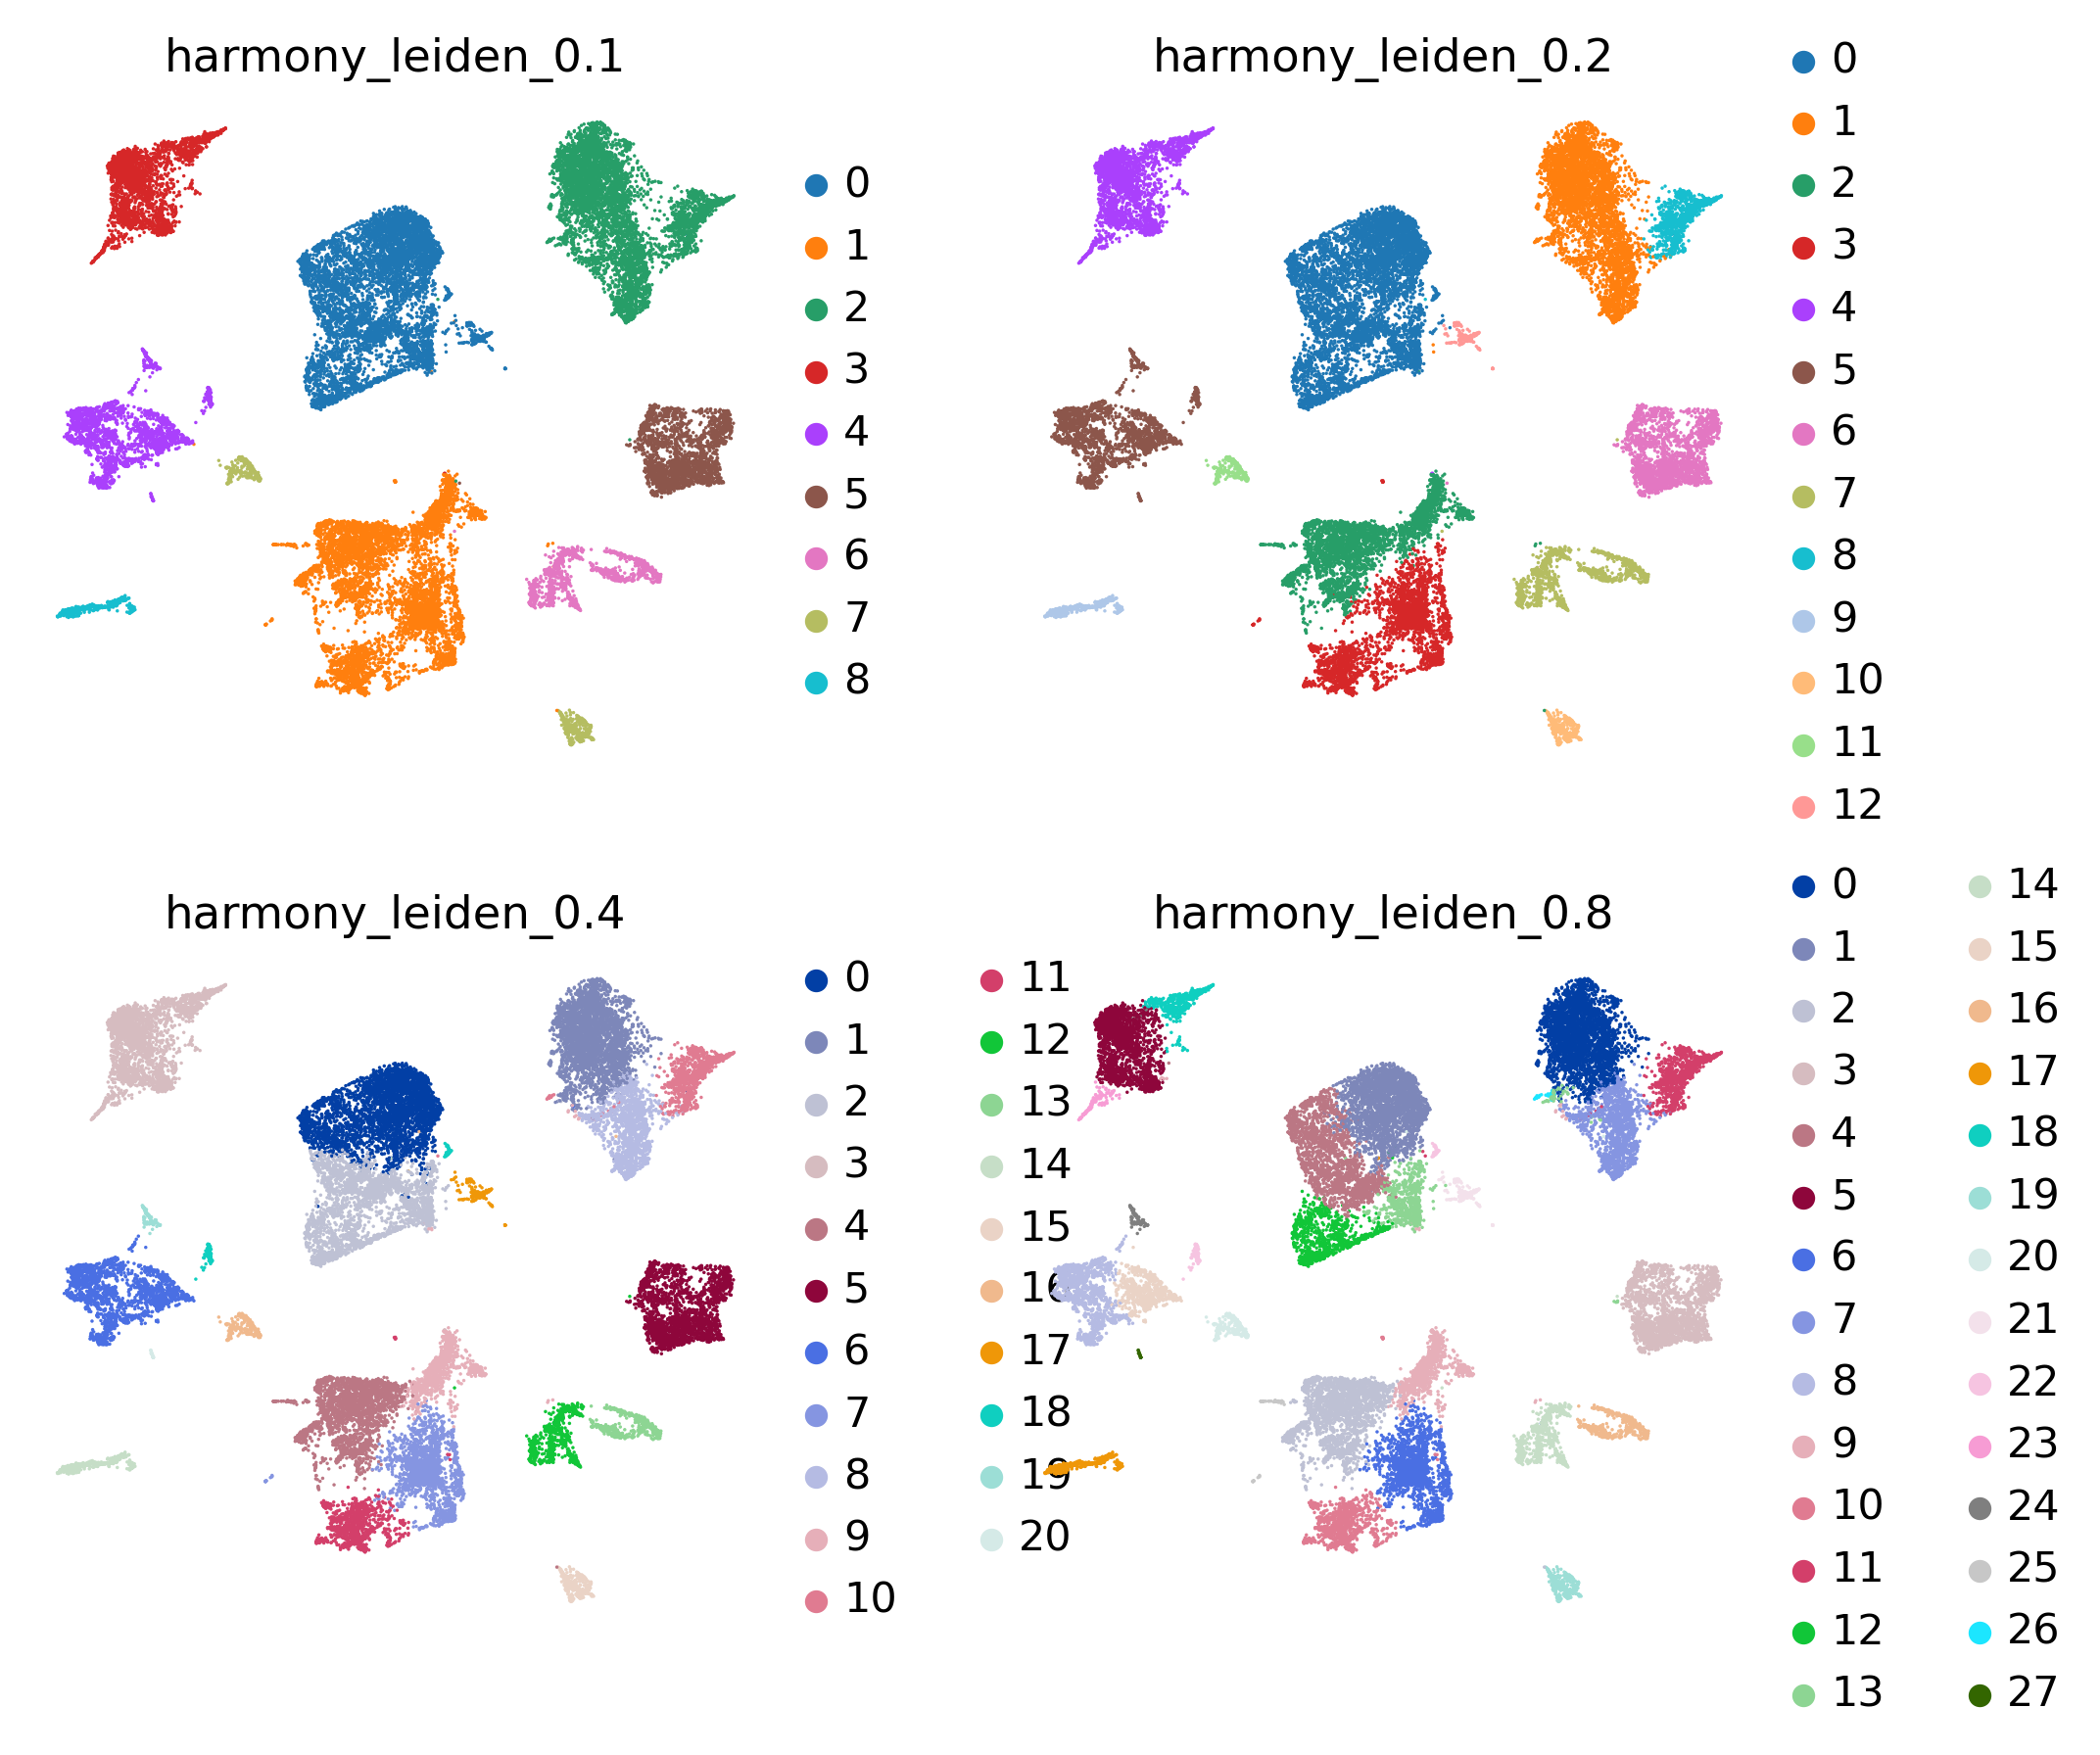

In [32]:
sc.pl.umap(adata, color=['harmony_leiden_0.1',"harmony_leiden_0.2", "harmony_leiden_0.4",'harmony_leiden_0.8'], frameon=False, ncols=2)

In [ ]:
sc.pl.umap(adata, color=['harmony_leiden_0.8'], groups = ['19','21','22','24','25','26','27'], frameon=False, ncols=2)

In [12]:
celltype = ['Endothelial','Epithelial','T_cell','B_cell','NK_cell','Macrophage','Mast','Monocyte','Dendritic','Normoblast','Fibroblast']
celltype_marker = {key: marker_genes_in_data[key] for key in celltype}

In [13]:
celltype_marker

{'Endothelial': ['VWF', 'CDH5', 'CLEC14A', 'CLDN5', 'ADGRL4'],
 'Epithelial': ['EPCAM', 'KRT19', 'KRT7', 'KRT8'],
 'T_cell': ['CD3D', 'CD3E', 'CD8A'],
 'B_cell': ['MS4A1', 'CD79A'],
 'NK_cell': ['NKG7', 'KLRD1', 'GZMB', 'GNLY', 'TYROBP', 'FCGR3A'],
 'Macrophage': ['TREM2', 'FOLR2', 'SPP1', 'CD14', 'CD163'],
 'Mast': ['CPA3', 'MS4A2', 'TPSB2'],
 'Monocyte': ['CSF1R', 'FCN1', 'CD14'],
 'Dendritic': ['CCR7', 'CD86', 'CLEC10A'],
 'Normoblast': [],
 'Fibroblast': ['COL1A1', 'COL1A2', 'COL3A1', 'LUM']}

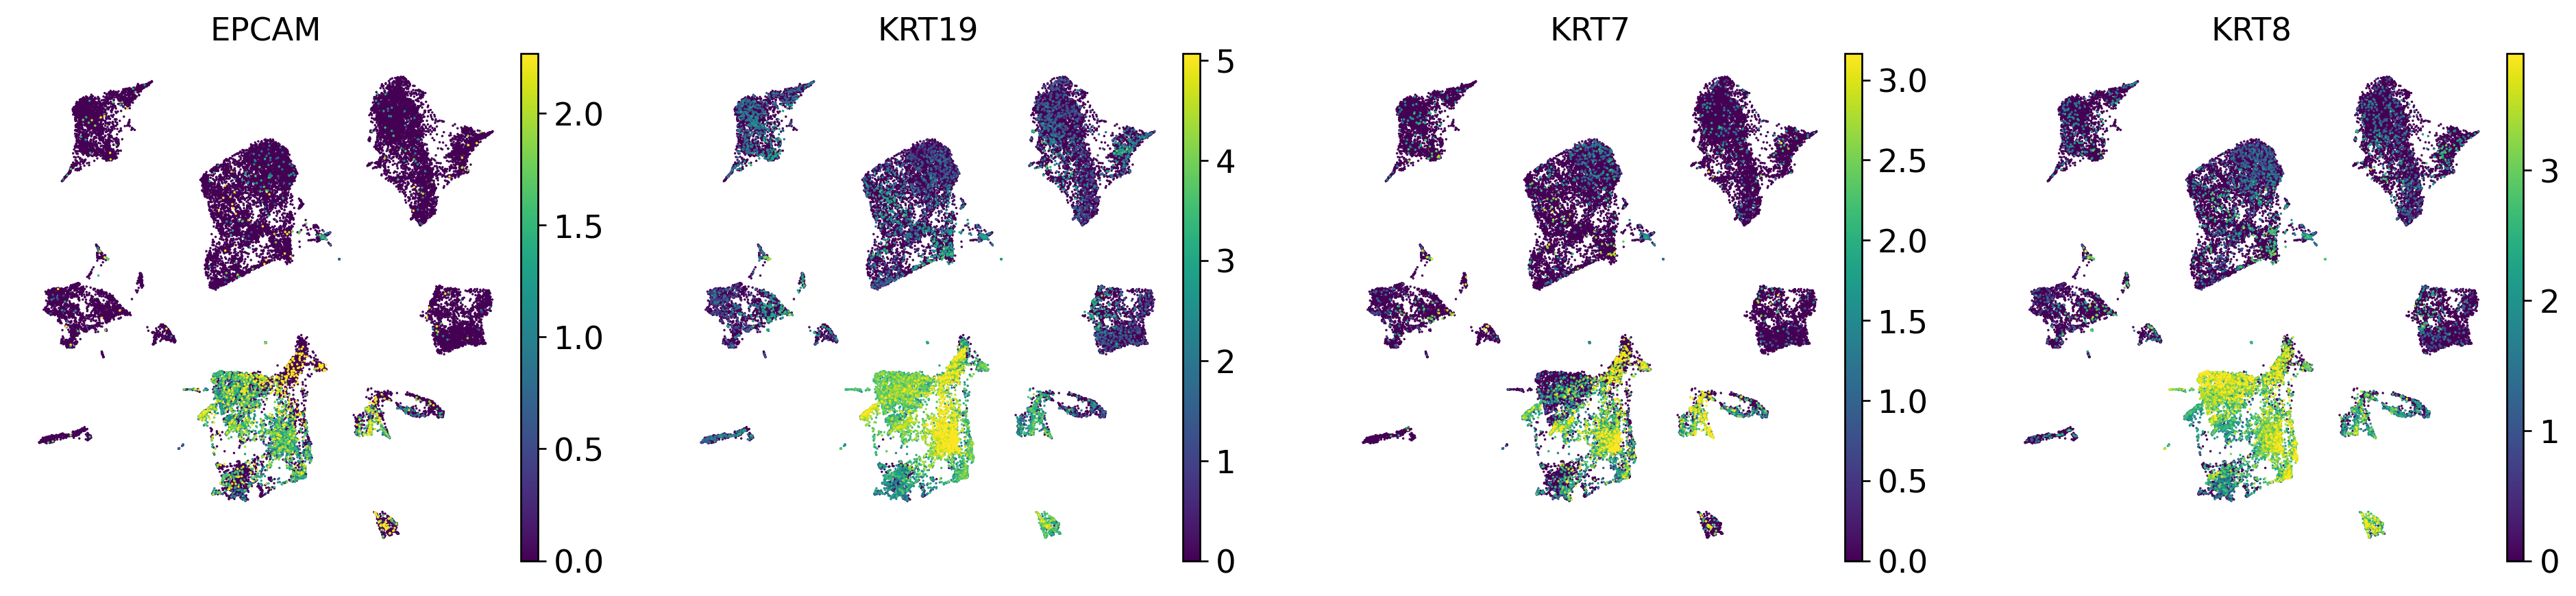

In [103]:
sc.pl.umap(adata, color=celltype_marker['Epithelial'], frameon=False, ncols=6, vmax='p99', use_raw=True)

In [101]:
pd.crosstab(adata.obs['harmony_leiden_0.8'],adata.obs['SampleID'] )

SampleID            P1013S2  P1015S2  P1018S1
harmony_leiden_0.8                           
0                       731      921     1420
1                       920      484     1330
2                       803      107     1379
3                       613     1199      351
4                       741      497      706
5                      1408      208      303
6                      1438      167      222
7                       284      869      306
8                       811      311      155
9                       645      321      117
10                      469      244      244
11                      336      371      240
12                      242      265      413
13                      203      165      387
14                      357      218       89
15                      363      267       30
16                       30      400       69
17                       16       14      457
18                      251       46      159
19                       54       15      343
20                       33      177       84
21                       18      163       45
22                       65       13       89
23                      102       11       30
24                       59       40       20
25                        0        0       62
26                        0        0       37
27                       12        5        4

In [113]:
adata_filter = adata[adata.obs['harmony_leiden_0.8'].isin(['19','21','22','24','25','26','27']) == False,:] 

In [114]:
adata_filter

View of AnnData object with n_obs × n_vars = 26961 × 3000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'PatientID', 'NeoChemoRes', 'NeoRadRes', 'SampleID', 'SampleTimepoint', 'SampleMethod', 'SampleDate', 'Kit', 'scDblFinder.score', 'scDblFinder.class', 'percent_mt', 'percent_hb', 'S.Score', 'G2M.Score', 'Phase', 'batch', 'n_genes', 'leiden_0.1', 'harmony_leiden_0.1', 'harmony_leiden_0.2', 'harmony_leiden_0.4', 'harmony_leiden_0.8'
    var: 'name-0', 'name-1', 'name-2', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_0.1_colors', 'SampleID_colors', 'harmony_leiden_0.1_colors', 'harmony_leiden_0.2_colors', 'harmony_leiden_0.4_colors', 'harmony_leiden_0.8_colors', 'rank_genes_groups', 'rank_genes_groups_filtered'
    obsm: 'X_pca', 'X_umap', 'X_pca_harmony'
    varm: 'PCs'
    layers: 'count'
    obsp: 'distances', 'connect

In [115]:
pd.crosstab(adata_filter.obs['harmony_leiden_0.8'],adata_filter.obs['SampleID'] )

SampleID            P1013S2  P1015S2  P1018S1
harmony_leiden_0.8                           
0                       731      921     1420
1                       920      484     1330
2                       803      107     1379
3                       613     1199      351
4                       741      497      706
5                      1408      208      303
6                      1438      167      222
7                       284      869      306
8                       811      311      155
9                       645      321      117
10                      469      244      244
11                      336      371      240
12                      242      265      413
13                      203      165      387
14                      357      218       89
15                      363      267       30
16                       30      400       69
17                       16       14      457
18                      251       46      159
19                       54       15      343
20                       33      177       84
23                      102       11       30

In [5]:
readata = sc.read_h5ad(resdir+'/cellranger_filter.h5ad')

In [170]:
readata.layers['count'] = readata.X.copy()

In [171]:
sc.pp.normalize_total(readata, target_sum=1e4)
sc.pp.log1p(readata)
readata.raw = readata

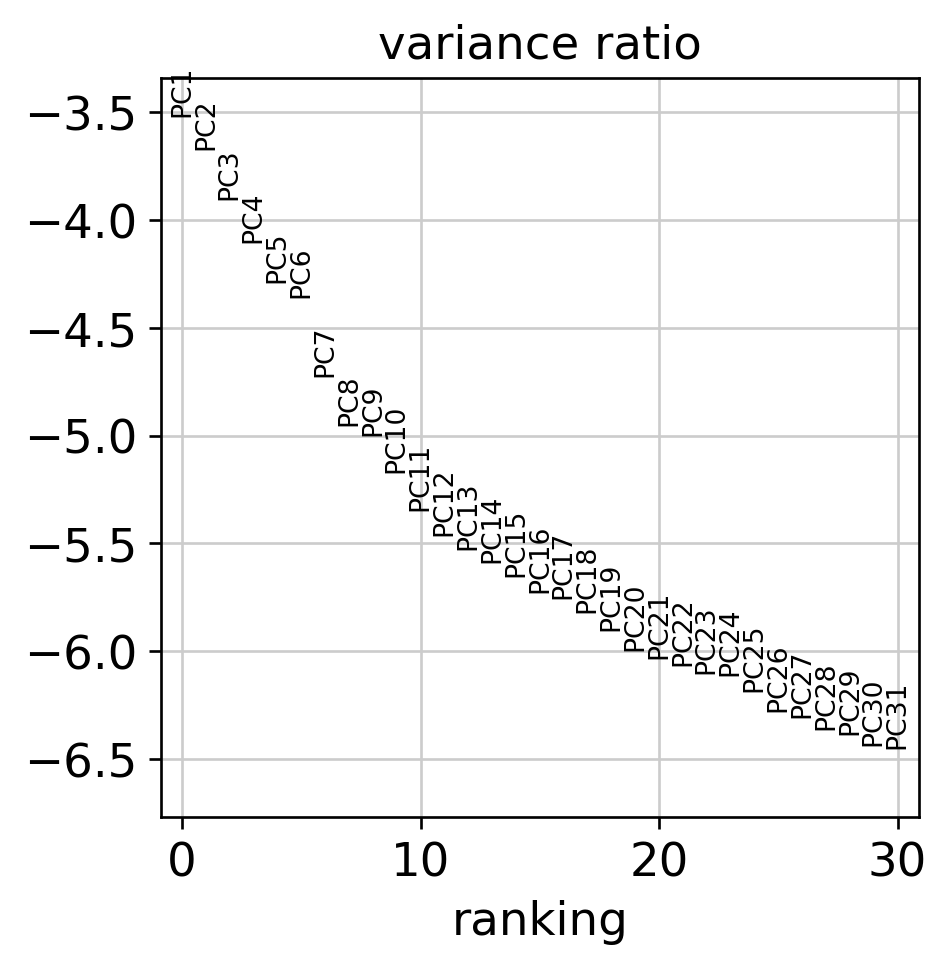

In [54]:
sc.pp.highly_variable_genes(
    readata,layer = 'count',
    flavor="seurat_v3",
    n_top_genes=3000,
    batch_key="SampleID",
    subset=True,
)
sc.pp.scale(readata)
sc.tl.pca(readata, svd_solver='arpack')
sc.pl.pca_variance_ratio(readata, log=True)

In [55]:
sce.pp.harmony_integrate(readata, 'SampleID')
sc.pp.neighbors(readata, use_rep='X_pca_harmony',n_neighbors=15, n_pcs=40)
for i in [0.2,0.4,0.6]:
    sc.tl.leiden(readata, resolution = i, key_added = ('re_leiden_'+str(i)))
sc.tl.umap(readata,min_dist=0.2)

2023-12-06 18:57:36,441 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...


2023-12-06 18:58:26,659 - harmonypy - INFO - sklearn.KMeans initialization complete.
2023-12-06 18:58:27,226 - harmonypy - INFO - Iteration 1 of 10
2023-12-06 18:58:59,222 - harmonypy - INFO - Iteration 2 of 10
2023-12-06 18:59:28,958 - harmonypy - INFO - Iteration 3 of 10
2023-12-06 18:59:59,597 - harmonypy - INFO - Iteration 4 of 10
2023-12-06 19:00:33,446 - harmonypy - INFO - Iteration 5 of 10
2023-12-06 19:01:02,753 - harmonypy - INFO - Converged after 5 iterations


/home/zhepan/miniconda3/envs/scRNA/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/zhepan/miniconda3/envs/scRNA/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/zhepan/miniconda3/envs/scRNA/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.ma

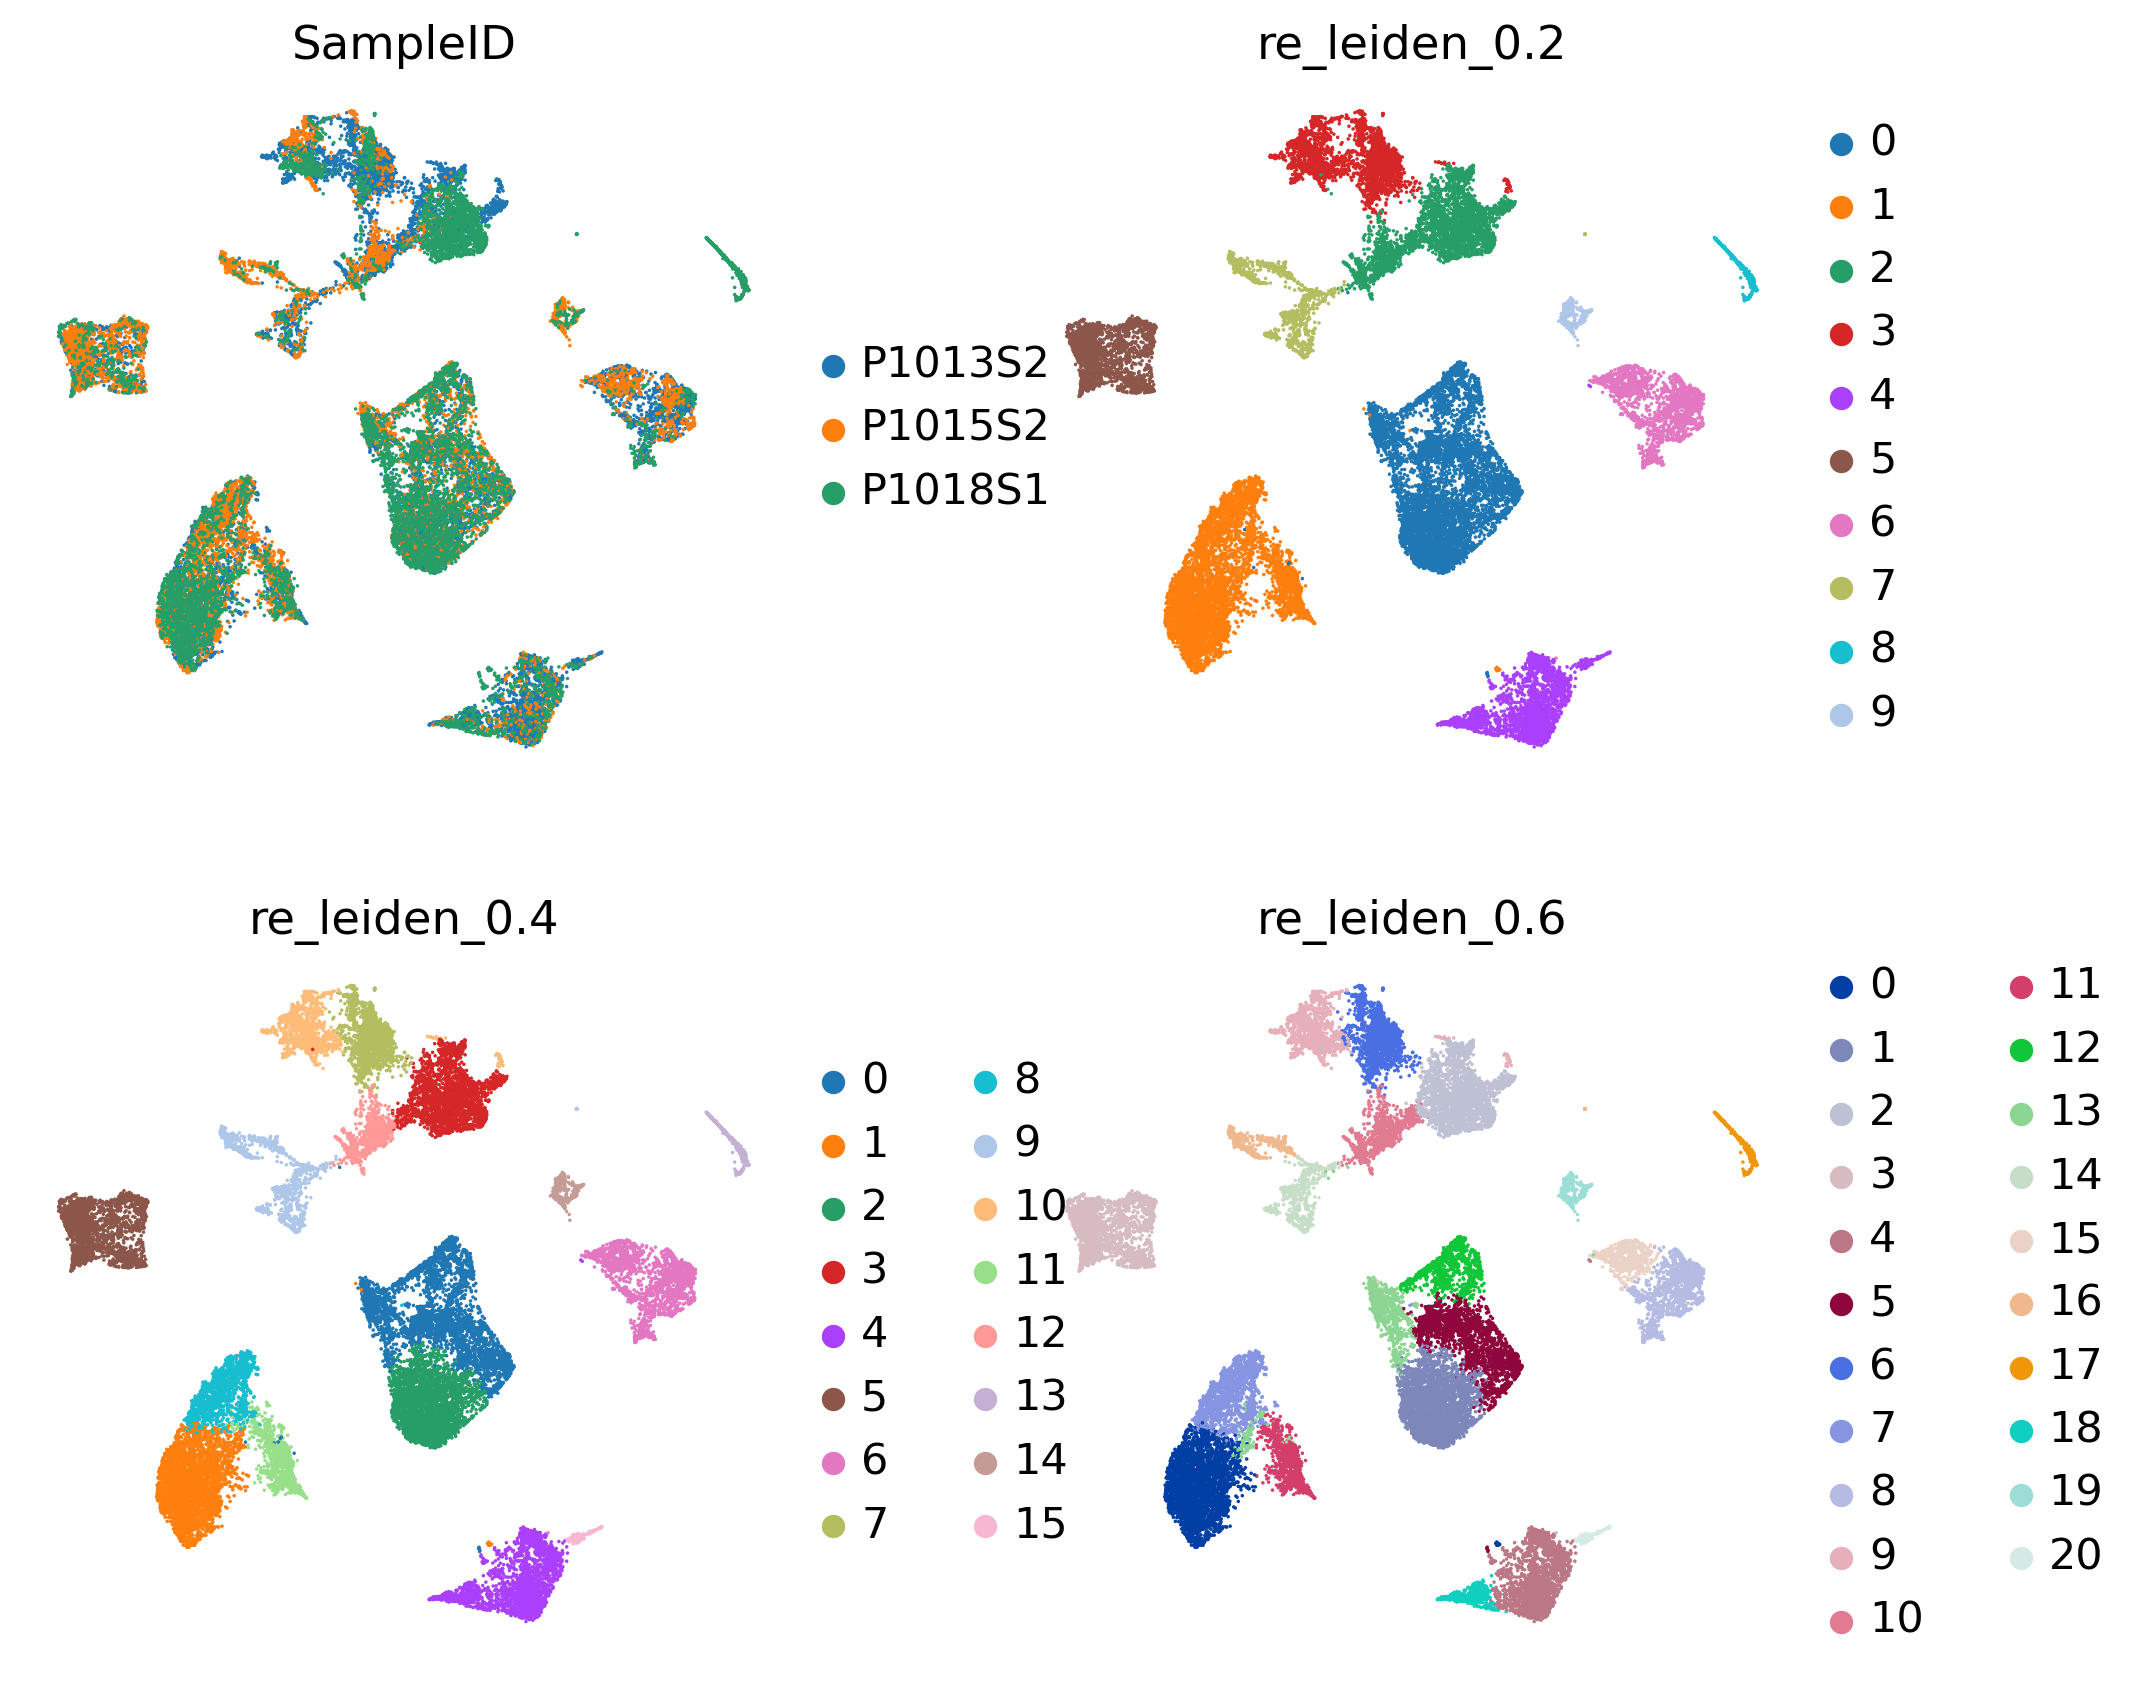

In [56]:
sc.pl.umap(readata, color=['SampleID','re_leiden_0.2',"re_leiden_0.4", "re_leiden_0.6"], frameon=False, ncols=2)

In [140]:
readata.obs['SampleID'].value_counts()

SampleID
P1013S2    10796
P1018S1     8491
P1015S2     7262
Name: count, dtype: int64

In [151]:
sc.pl.umap(readata, color=['SampleTimepoint'],title = ['Treatment'], 
        frameon=False, legend_fontsize='xx-small', show=False , save = 'treatment.png')
sc.pl.umap(readata, color=['SampleID'],title = ['Sample'], 
        frameon=False, legend_fontsize='xx-small', show=False , save = 'sample.png')
sc.pl.umap(readata, color=['manual_celltype_annotation'],title = ['Celltype'], 
        frameon=False, legend_fontsize='xx-small', show=False , save = 'celltype.png')        

/home/zhepan/miniconda3/envs/scRNA/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/zhepan/miniconda3/envs/scRNA/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/home/zhepan/miniconda3/envs/scRNA/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/zhepan/miniconda3/envs/scRNA/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/home/zhepan/miniconda3/envs/scRNA/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/zhepan/miniconda3/envs/scRNA/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<Axes: title={'center': 'Celltype'}, xlabel='UMAP1', ylabel='UMAP2'>

In [14]:
celltype_marker

{'Endothelial': ['VWF', 'CDH5', 'CLEC14A', 'CLDN5', 'ADGRL4'],
 'Epithelial': ['EPCAM', 'KRT19', 'KRT7', 'KRT8'],
 'T_cell': ['CD3D', 'CD3E', 'CD8A'],
 'B_cell': ['MS4A1', 'CD79A'],
 'NK_cell': ['NKG7', 'KLRD1', 'GZMB', 'GNLY', 'TYROBP', 'FCGR3A'],
 'Macrophage': ['TREM2', 'FOLR2', 'SPP1', 'CD14', 'CD163'],
 'Mast': ['CPA3', 'MS4A2', 'TPSB2'],
 'Monocyte': ['CSF1R', 'FCN1', 'CD14'],
 'Dendritic': ['CCR7', 'CD86', 'CLEC10A'],
 'Normoblast': [],
 'Fibroblast': ['COL1A1', 'COL1A2', 'COL3A1', 'LUM']}

In [ ]:
sc.pl.umap(readata, color=['VWF', 'CDH5', 'CLEC14A',
                            'EPCAM', 'KRT19', 'KRT8',
                            'ACTA2','NOTCH3',
                            'PTPRC','CD3D','NKG7',
                            'CD79A','MS4A1'
                            'TREM2', 'FOLR2', 'SPP1',
                            'CPA3', 'MS4A2',
                            'COL1A1', 'COL1A2', 'COL3A1',
                            ], frameon=False, ncols=2, save = '2feature.png' )

In [72]:
cl_annotation={
    "0": "Endothelial",
    "1": "Stromal",
    "2": "Epithelial",
    "3": "Epithelial",
    "4": "T cell",
    "5": "Fibroblast",
    "6": "Macro/Mono",
    "7": "Epithelial",
    "8": "Mast",
    "9": "B cell",
}
readata.obs["manual_celltype_annotation"] = readata.obs['re_leiden_0.2'].map(cl_annotation)
readata.obs['manual_celltype_annotation'].to_csv(os.path.join(resdir,'annotation','manual_annotation.csv'))

/home/zhepan/miniconda3/envs/scRNA/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/zhepan/miniconda3/envs/scRNA/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/zhepan/miniconda3/envs/scRNA/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.ma

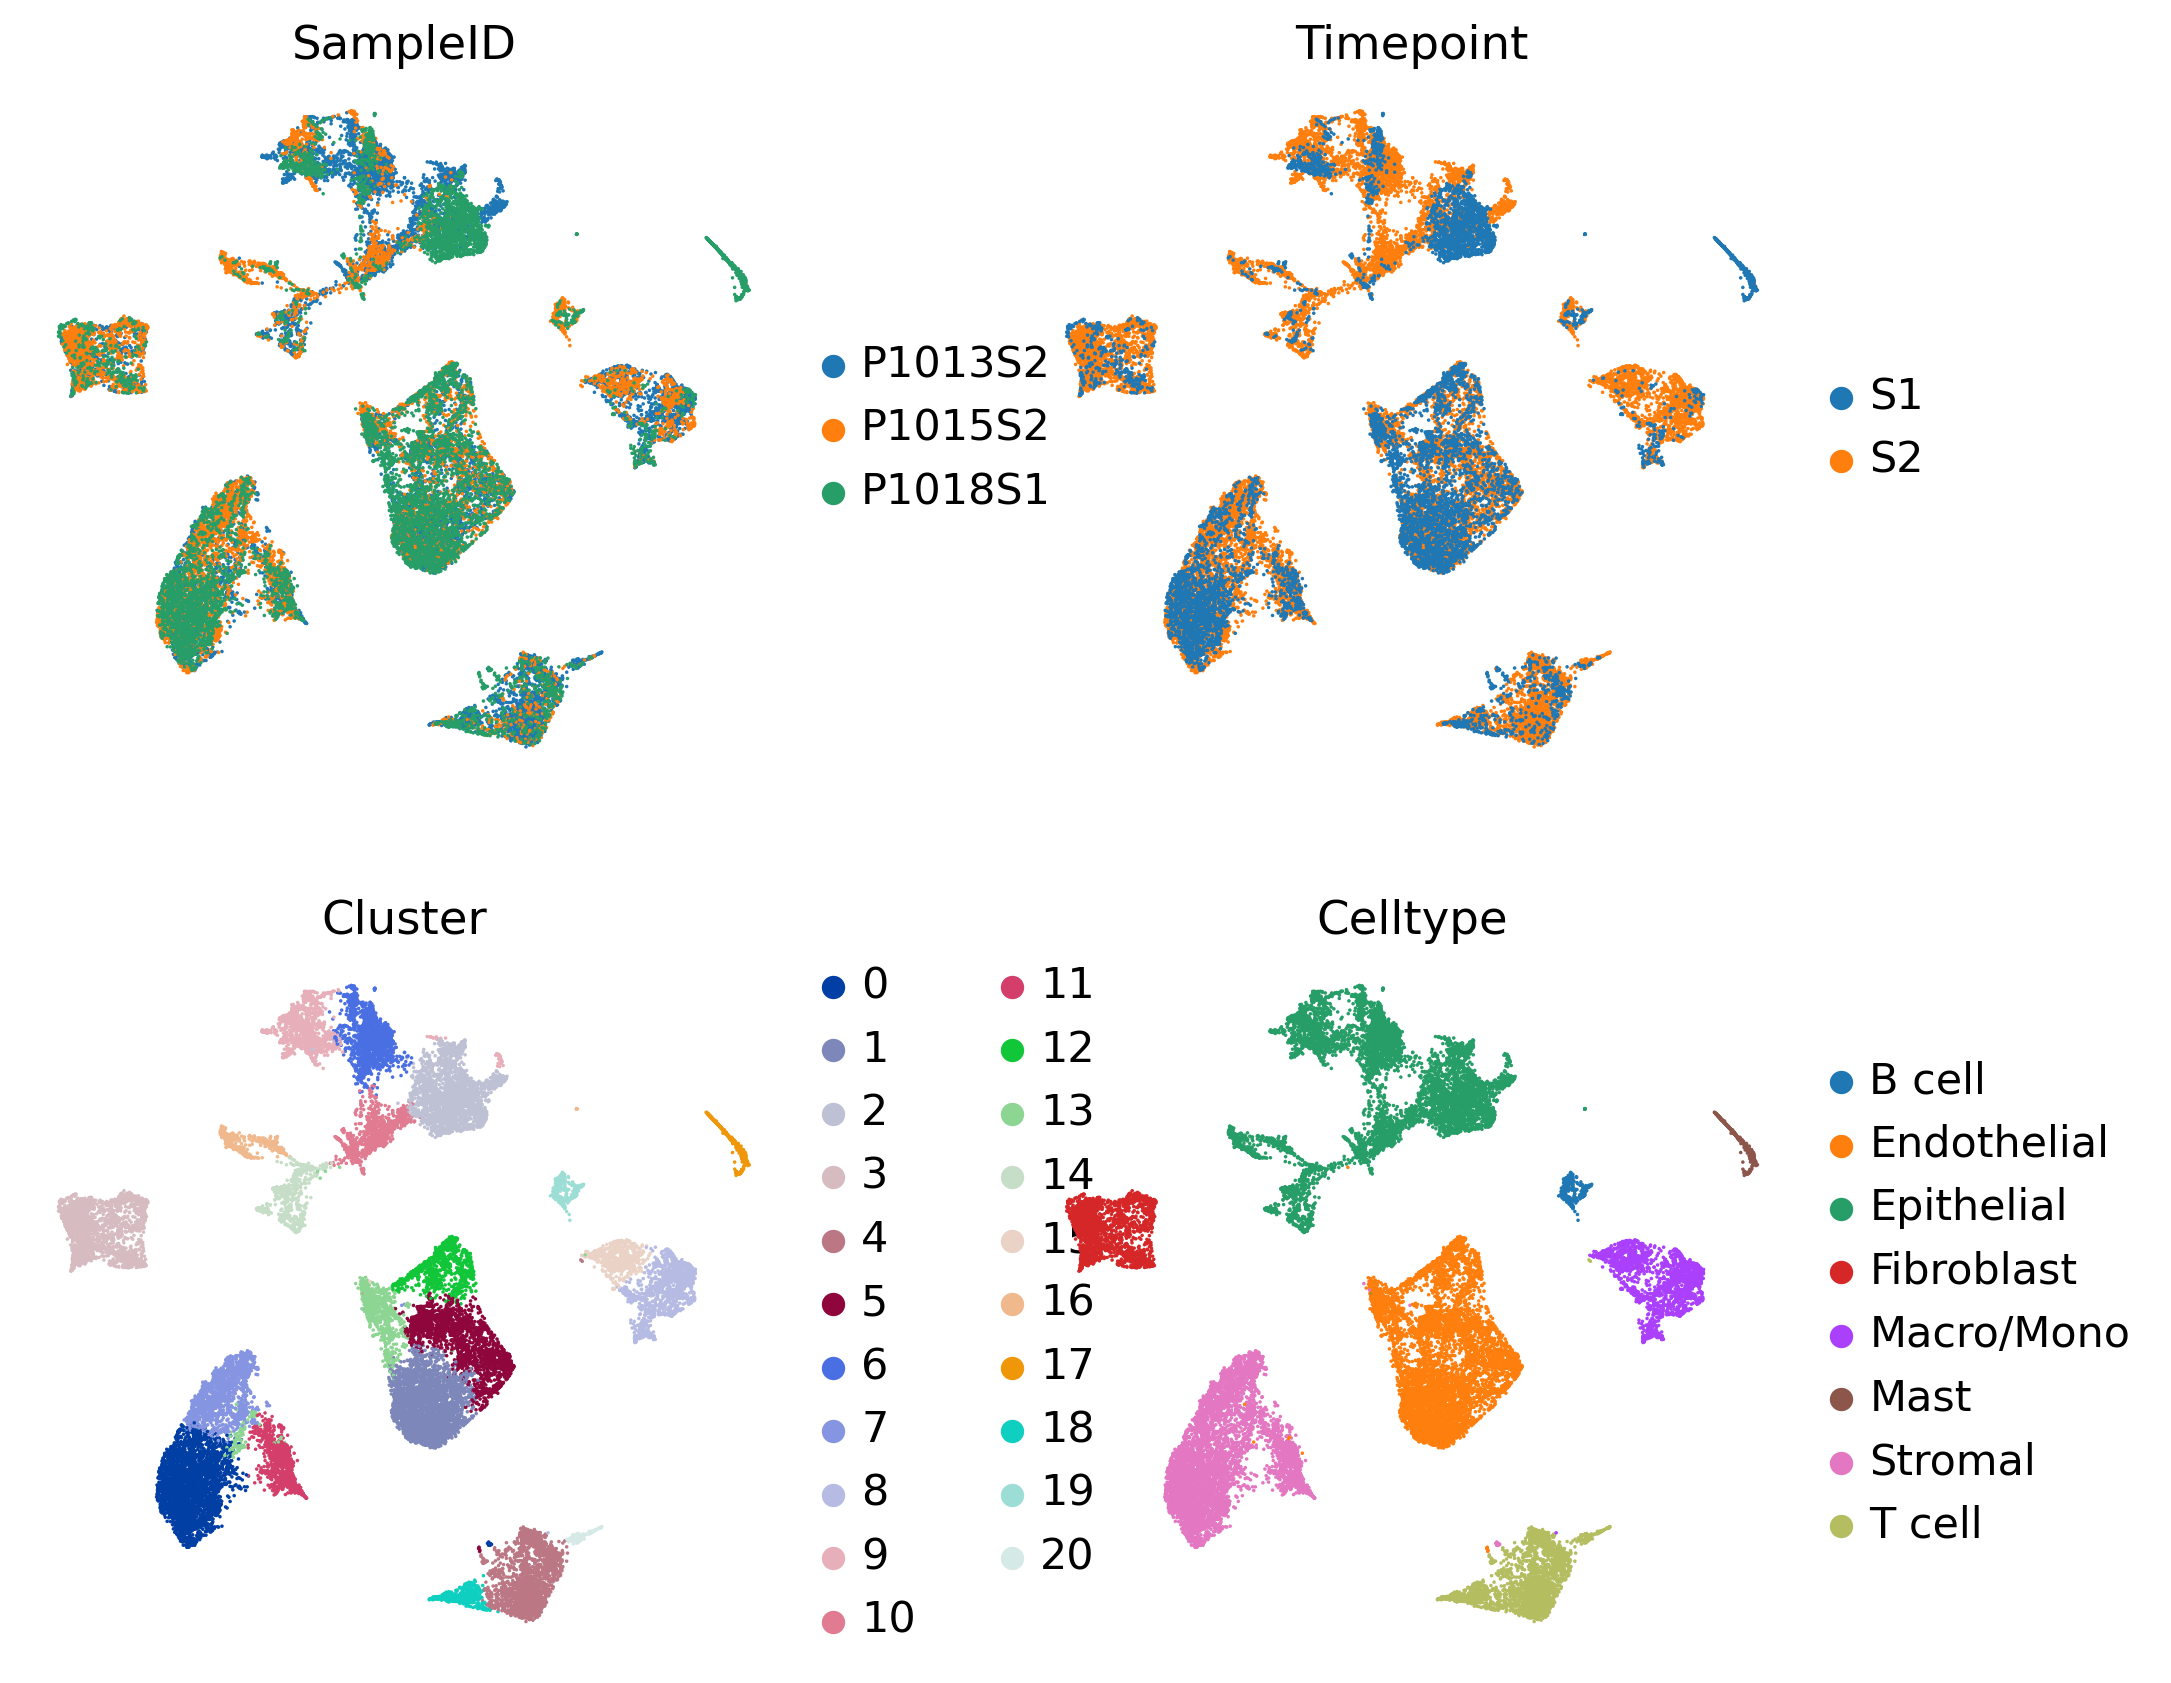

In [73]:
sc.pl.umap(readata, color=["SampleID", "SampleTimepoint","re_leiden_0.6","manual_celltype_annotation"],title = ['SampleID','Timepoint','Cluster','Celltype'],
    frameon=False, ncols=2, save = '_'+filtertype+'_final_harmony.pdf')

In [22]:
pd.crosstab(readata.obs['re_leiden_0.4'],readata.obs['SampleID'] )

SampleID       P1013S2  P1015S2  P1018S1
re_leiden_0.4                           
0                 1137      936     1418
1                  773      948     1499
2                  970      524     1408
3                 1010      103     1357
4                 1666      261      464
5                  615     1198      346
6                 1186      581      191
7                 1202      155      221
8                  234      825      280
9                  402      609      155
10                 588      258      275
11                 342      392      236
12                 529      274       79
13                  16       14      456
14                  34      175       83
15                  92        9       23

In [10]:
filter_count = adata[adata.obs_names.isin(readata.obs_names),:]

In [11]:
filter_count.write_h5ad(os.path.join(resdir,'cellranger_filter_count.h5ad'))

/home/zhepan/miniconda3/envs/scRNA/lib/python3.9/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  df[key] = c
/home/zhepan/miniconda3/envs/scRNA/lib/python3.9/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  df[key] = c
/home/zhepan/miniconda3/envs/scRNA/lib/python3.9/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  df[key] = c


In [23]:
marker_genes_in_data = dict()
for ct, markers in canonical_markers.items():
    markers_found = list()
    for marker in markers:
        if marker in readata.var.index:
            markers_found.append(marker)
    marker_genes_in_data[ct] = markers_found

celltype = ['Endothelial','Epithelial','T_cell','B_cell','NK_cell','Macrophage','Mast','Monocyte','Dendritic','Normoblast','Fibroblast']
celltype_marker = {key: marker_genes_in_data[key] for key in celltype}

In [ ]:
redata_save

/home/zhepan/miniconda3/envs/scRNA/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/home/zhepan/miniconda3/envs/scRNA/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
/home/zhepan/miniconda3/envs/scRNA/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(

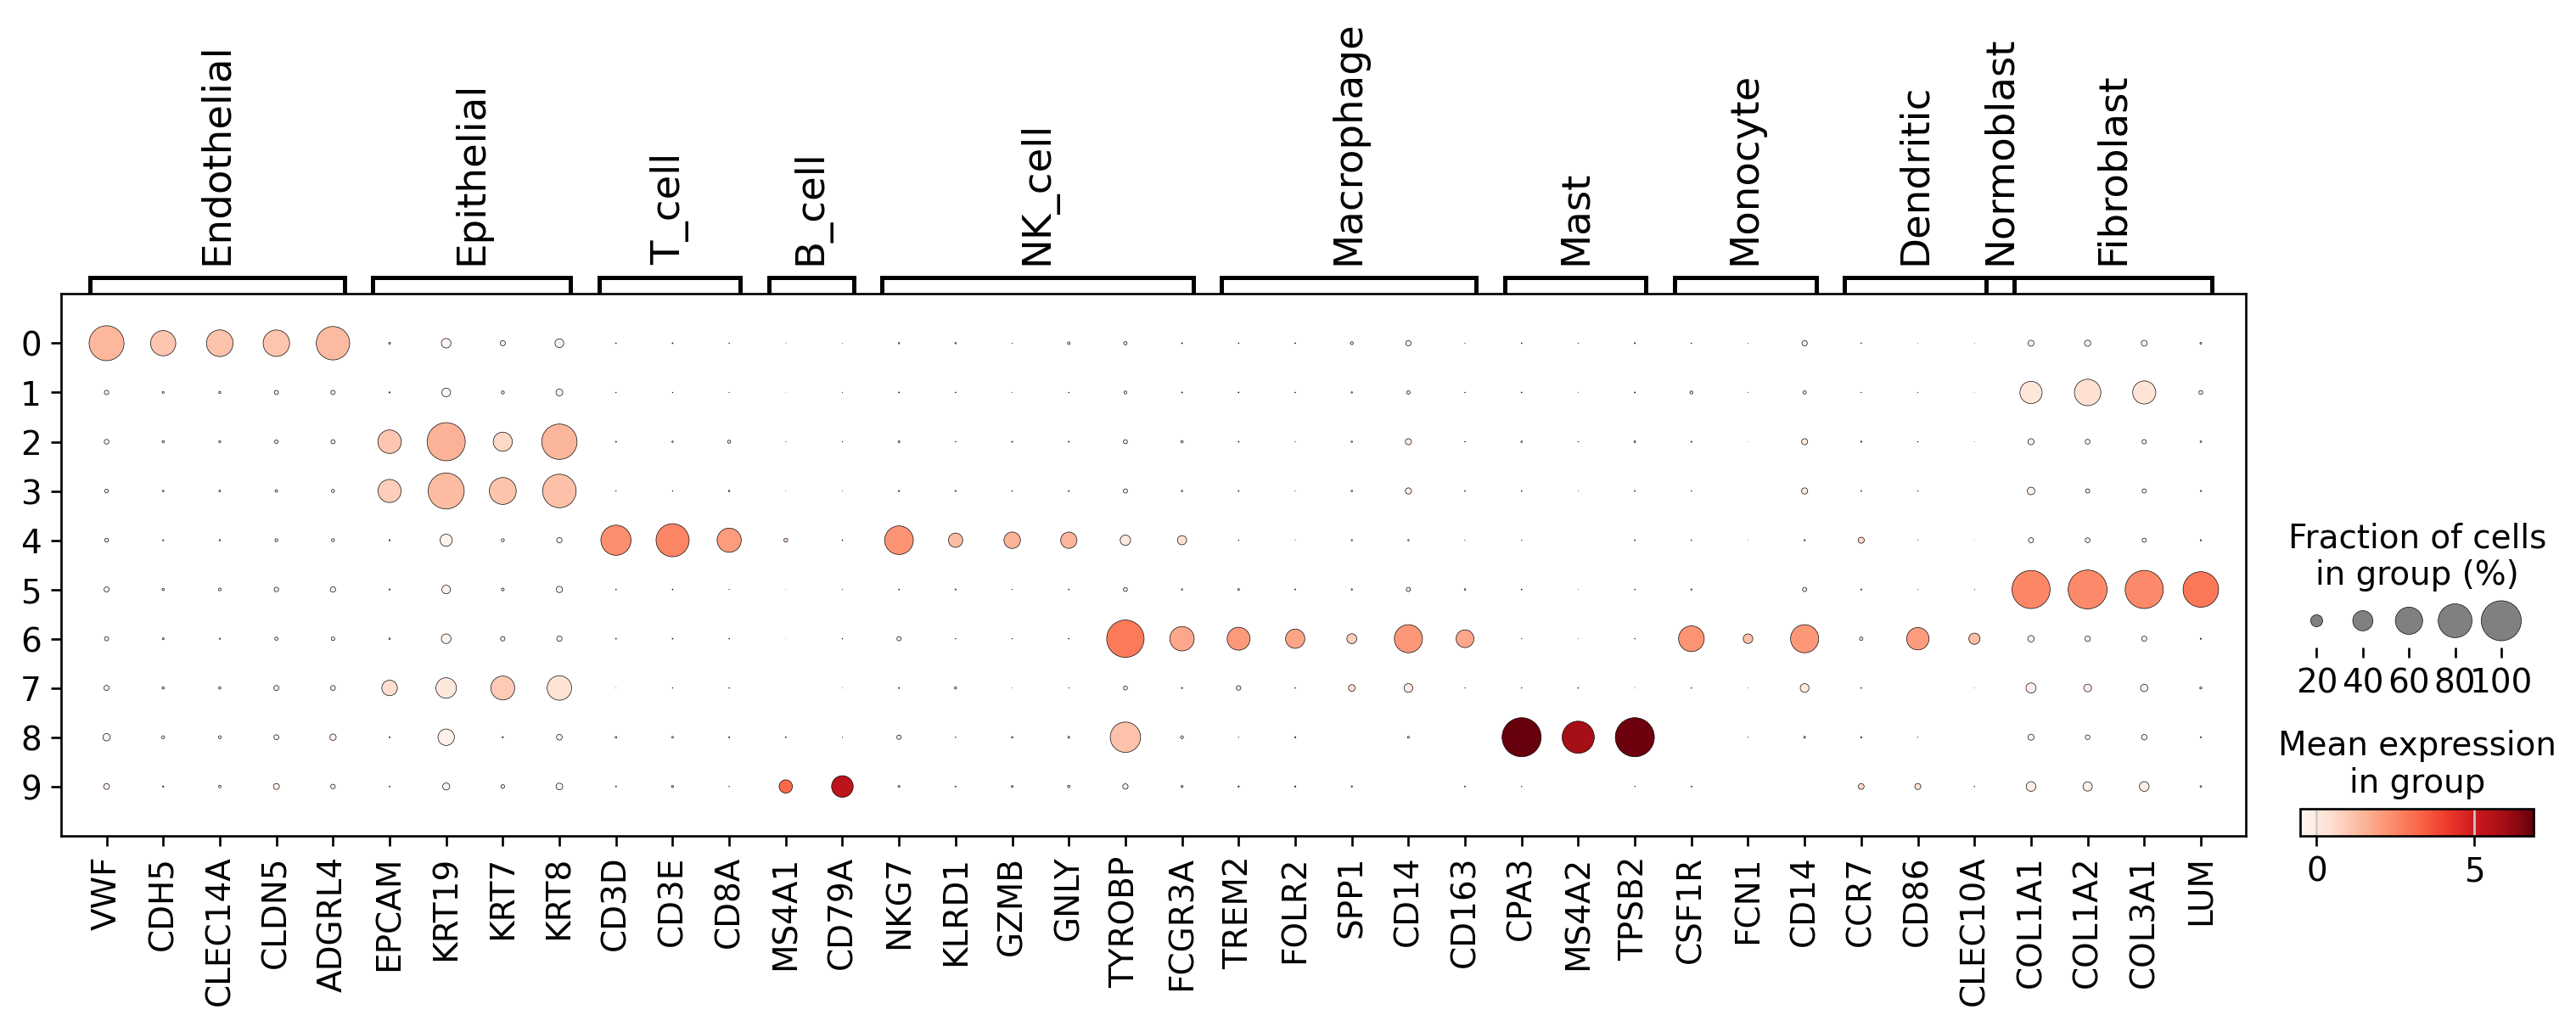

In [84]:
sc.pl.dotplot(readata, celltype_marker, 're_leiden_0.2',dendrogram=False, swap_axes=False)

In [79]:
redata_save.obs = readata.obs

In [ ]:
sc.pl.stacked_violin(redata_save, celltype_marker, groupby='re_leiden_0.6',
                     swap_axes=False, dendrogram=False,
                     row_palette='Paired')

In [102]:
readata.obs

orig.ident  nCount_RNA  nFeature_RNA PatientID NeoChemoRes  \
AACCTGAGAATTGTG-0    P1013S2      2849.0          1680     P1013         PCR   
AACCTGAGCGATAGC-0    P1013S2      2355.0          1319     P1013         PCR   
AACCTGAGCGCTTAT-0    P1013S2      2124.0          1342     P1013         PCR   
AACCTGAGCGTCTAT-0    P1013S2      4421.0          1702     P1013         PCR   
AACCTGAGTACTTGC-0    P1013S2      9980.0          3721     P1013         PCR   
...                      ...         ...           ...       ...         ...   
TTGTCAGTTAGTGGG-2    P1018S1      7582.0          2936     P1018         PCR   
TTGTCAGTTCCATGA-2    P1018S1       826.0           557     P1018         PCR   
TTGTCAGTTCTGTTT-2    P1018S1       851.0           645     P1018         PCR   
TTGTCATCACAGTAC-2    P1018S1      6392.0          2897     P1018         PCR   
TTGTCATCAGCGATT-2    P1018S1       554.0           456     P1018         PCR   

                  NeoRadRes SampleID SampleTimepoint SampleMethod SampleDate  \
AACCTGAGAATTGTG-0       PCR  P1013S2              S2      surgery   20231102   
AACCTGAGCGATAGC-0       PCR  P1013S2              S2      surgery   20231102   
AACCTGAGCGCTTAT-0       PCR  P1013S2              S2      surgery   20231102   
AACCTGAGCGTCTAT-0       PCR  P1013S2              S2      surgery   20231102   
AACCTGAGTACTTGC-0       PCR  P1013S2              S2      surgery   20231102   
...                     ...      ...             ...          ...        ...   
TTGTCAGTTAGTGGG-2       PCR  P1018S1              S1       biopsy   20231107   
TTGTCAGTTCCATGA-2       PCR  P1018S1              S1       biopsy   20231107   
TTGTCAGTTCTGTTT-2       PCR  P1018S1              S1       biopsy   20231107   
TTGTCATCACAGTAC-2       PCR  P1018S1              S1       biopsy   20231107   
TTGTCATCAGCGATT-2       PCR  P1018S1              S1       biopsy   20231107   

                   ... percent_mt  percent_hb   S.Score  G2M.Score  Phase  \
AACCTGAGAATTGTG-0  ...   4.352404    0.000000  0.068854  -0.026930      S   
AACCTGAGCGATAGC-0  ...   1.104034    0.000000 -0.058762   0.023214    G2M   
AACCTGAGCGCTTAT-0  ...   7.580038    0.000000 -0.082566  -0.039214     G1   
AACCTGAGCGTCTAT-0  ...   1.492875    0.000000 -0.025413  -0.038280     G1   
AACCTGAGTACTTGC-0  ...   2.104208    0.000000  0.005813  -0.033792      S   
...                ...        ...         ...       ...        ...    ...   
TTGTCAGTTAGTGGG-2  ...   7.583751    0.039567 -0.039406  -0.005330     G1   
TTGTCAGTTCCATGA-2  ...   2.300242    0.121065  0.024575  -0.062997      S   
TTGTCAGTTCTGTTT-2  ...   3.290247    0.117509  0.041155  -0.014583      S   
TTGTCATCACAGTAC-2  ...  10.028160    0.062578  0.032300  -0.040732      S   
TTGTCATCAGCGATT-2  ...   1.263538    0.000000 -0.038508   0.057572    G2M   

                   batch  re_leiden_0.2 re_leiden_0.4 re_leiden_0.6  \
AACCTGAGAATTGTG-0      0              3             7             6   
AACCTGAGCGATAGC-0      0              4             4             4   
AACCTGAGCGCTTAT-0      0              7             9            14   
AACCTGAGCGTCTAT-0      0              6             6             8   
AACCTGAGTACTTGC-0      0              3             7             6   
...                  ...            ...           ...           ...   
TTGTCAGTTAGTGGG-2      2              2             3             2   
TTGTCAGTTCCATGA-2      2              0             0            13   
TTGTCAGTTCTGTTT-2      2              0             0            13   
TTGTCATCACAGTAC-2      2              2             3             2   
TTGTCATCAGCGATT-2      2              0             0            13   

                  manual_celltype_annotation  
AACCTGAGAATTGTG-0                 Epithelial  
AACCTGAGCGATAGC-0                     T cell  
AACCTGAGCGCTTAT-0                 Epithelial  
AACCTGAGCGTCTAT-0                 Macro/Mono  
AACCTGAGTACTTGC-0                 Epithelial  
...                                 

In [74]:
readata.write_h5ad(os.path.join(resdir,'cellranger_filter.h5ad'))

### 1.6 DE

In [189]:
anno = pd.read_csv(os.path.join(resdir,'annotation','manual_annotation.csv'),index_col=0)

In [190]:
readata.obs = readata.obs.join(anno)

In [ ]:
readata.obs

In [193]:
sc.pp.normalize_total(readata, target_sum = 1e4)
sc.pp.log1p(readata)

In [194]:
sc.tl.rank_genes_groups(readata, 'manual_celltype_annotation', method='wilcoxon')
sc.tl.filter_rank_genes_groups(readata, min_fold_change=1.5)

/home/zhepan/miniconda3/envs/scRNA/lib/python3.9/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


In [198]:
df_markers = sc.get.rank_genes_groups_df(readata, group=readata.obs['manual_celltype_annotation'].unique(), key='rank_genes_groups')
df_markers = df_markers.loc[~ df_markers.names.isna()]
df_markers.to_csv(resdir + 'markers.csv')

In [199]:
df_markers

group   names     scores  logfoldchanges         pvals     pvals_adj
0       B cell    IGKC  16.144474        9.094280  1.242030e-58  3.594187e-54
1       B cell  JCHAIN  15.317967        9.121789  5.800282e-53  7.141106e-49
2       B cell    MZB1  13.786031        6.473852  3.093173e-43  1.491837e-39
3       B cell    SSR4  13.243087        2.200097  4.947297e-40  1.789561e-36
4       B cell   IGHG1  13.200779        8.450524  8.683280e-40  2.791964e-36
...        ...     ...        ...             ...           ...           ...
231499  T cell    LMNA -47.022259       -3.259144  0.000000e+00  0.000000e+00
231500  T cell     APP -49.039833       -4.019174  0.000000e+00  0.000000e+00
231501  T cell     GSN -50.260963       -4.330294  0.000000e+00  0.000000e+00
231502  T cell  IFITM3 -54.582153       -3.765868  0.000000e+00  0.000000e+00
231503  T cell    CST3 -57.116680       -4.173308  0.000000e+00  0.000000e+00

[231504 rows x 6 columns]

In [203]:
df_markers['group'].value_counts()

group
B cell         28938
Endothelial    28938
Epithelial     28938
Fibroblast     28938
Macro/Mono     28938
Mast           28938
Stromal        28938
T cell         28938
Name: count, dtype: int64

In [205]:
df_markers[df_markers['group'] == 'Macro/Mono'].head(10)['names']  # group 3 marker genes

115752      TYROBP
115753         FTL
115754        CD74
115755     HLA-DRA
115756       IFI30
115757    HLA-DRB1
115758    HLA-DPA1
115759      FCER1G
115760    HLA-DPB1
115761        CD68
Name: names, dtype: object

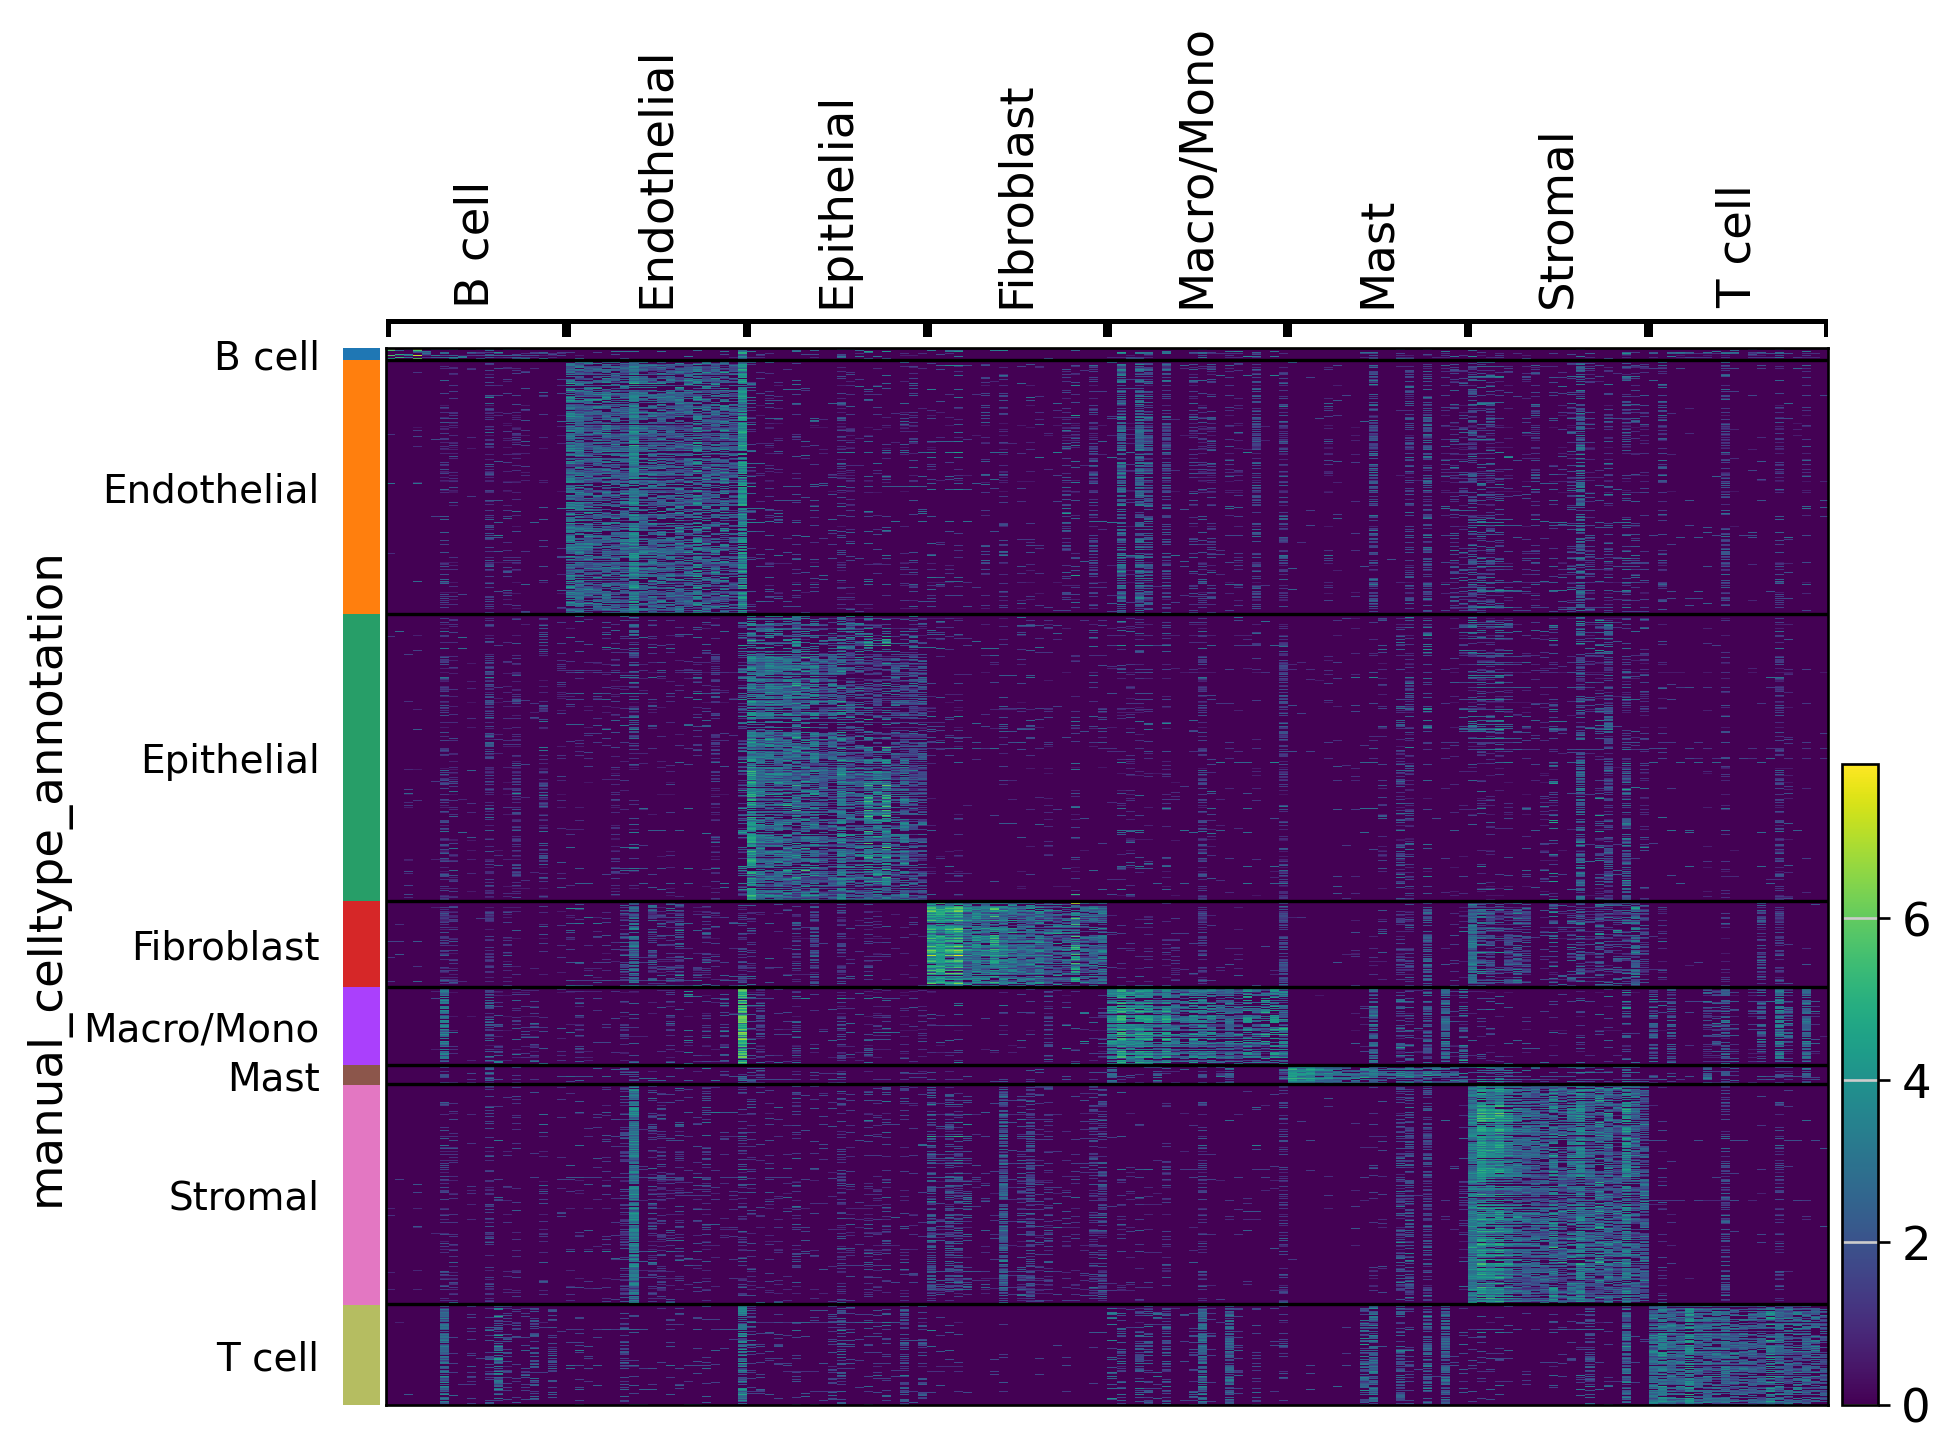

In [211]:
sc.pl.rank_genes_groups_heatmap(readata, key='rank_genes_groups_filtered',dendrogram=False,n_genes =20)

/home/zhepan/miniconda3/envs/scRNA/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/home/zhepan/miniconda3/envs/scRNA/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
/home/zhepan/miniconda3/envs/scRNA/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(

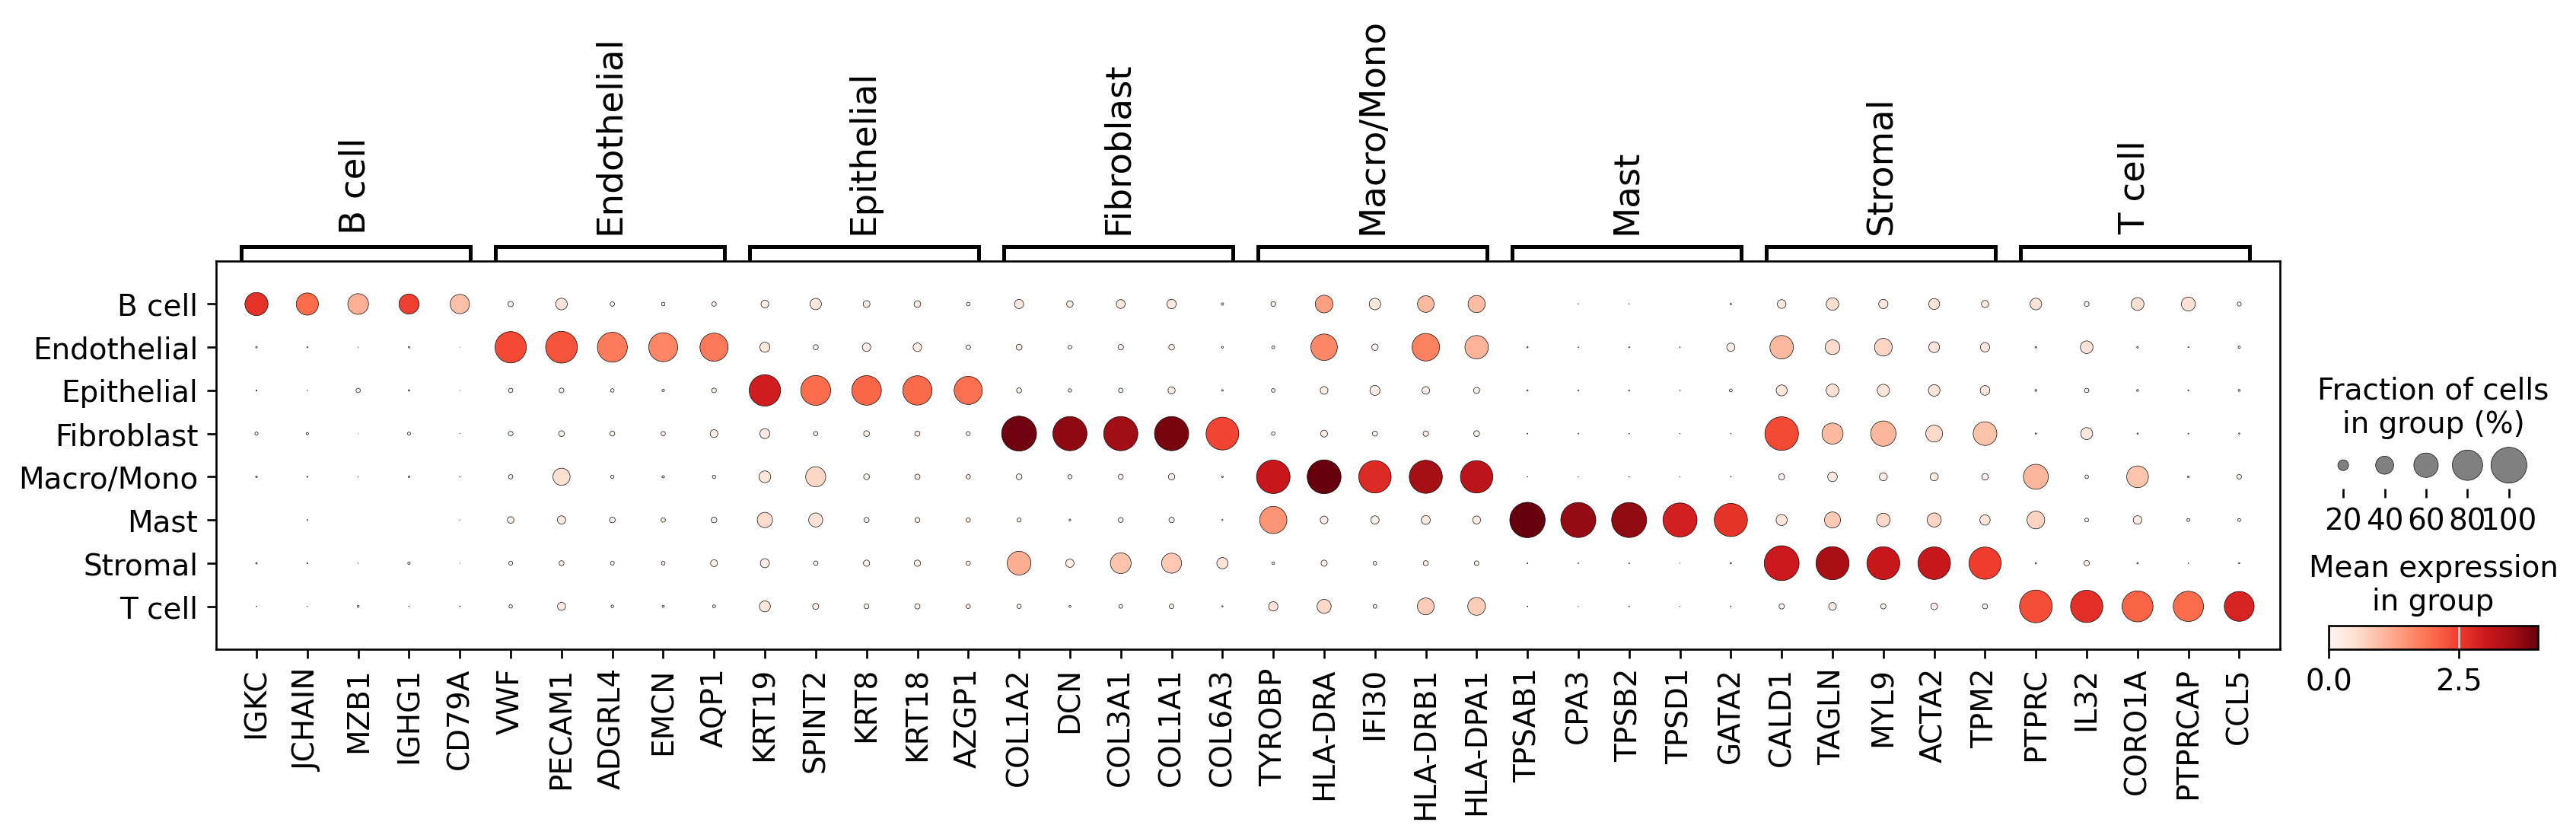

In [210]:
#sc.pl.rank_genes_groups(adata, key='rank_genes_groups_filtered')
sc.pl.rank_genes_groups_dotplot(readata, key='rank_genes_groups_filtered',dendrogram=False,n_genes =5)

In [224]:
sc.pl.rank_genes_groups_stacked_violin(readata, key='rank_genes_groups_filtered',dendrogram=False,n_genes =5,row_palette=readata.uns['manual_celltype_annotation_colors'],
                                        show = False, save = 'destack.png')

/home/zhepan/miniconda3/envs/scRNA/lib/python3.9/site-packages/scanpy/plotting/_stacked_violin.py:324: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  _color_df = _matrix.groupby(level=0).median()
/home/zhepan/miniconda3/envs/scRNA/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/zhepan/miniconda3/envs/scRNA/lib/python3.9/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_

{'mainplot_ax': <Axes: >, 'gene_group_ax': <Axes: >}

### 1.7 Enrichment

In [ ]:
# enrichment.R

In [89]:
import gseapy as gp
import decoupler as dc

In [ ]:
enr = gp.enrichr(df_markers[df_markers['group'] == 'Stormal'].head(50)['names'],
                gene_sets=['Azimuth_2023'], organism='human', outdir=None)
enr.results.head(5)

In [ ]:
sc.queries.enrich(adata, group='2', org="hsapiens", gprofiler_kwargs = {'sources' : ['GO:CC']} )

## 2 After annotation

### 2.1 Cell state composition

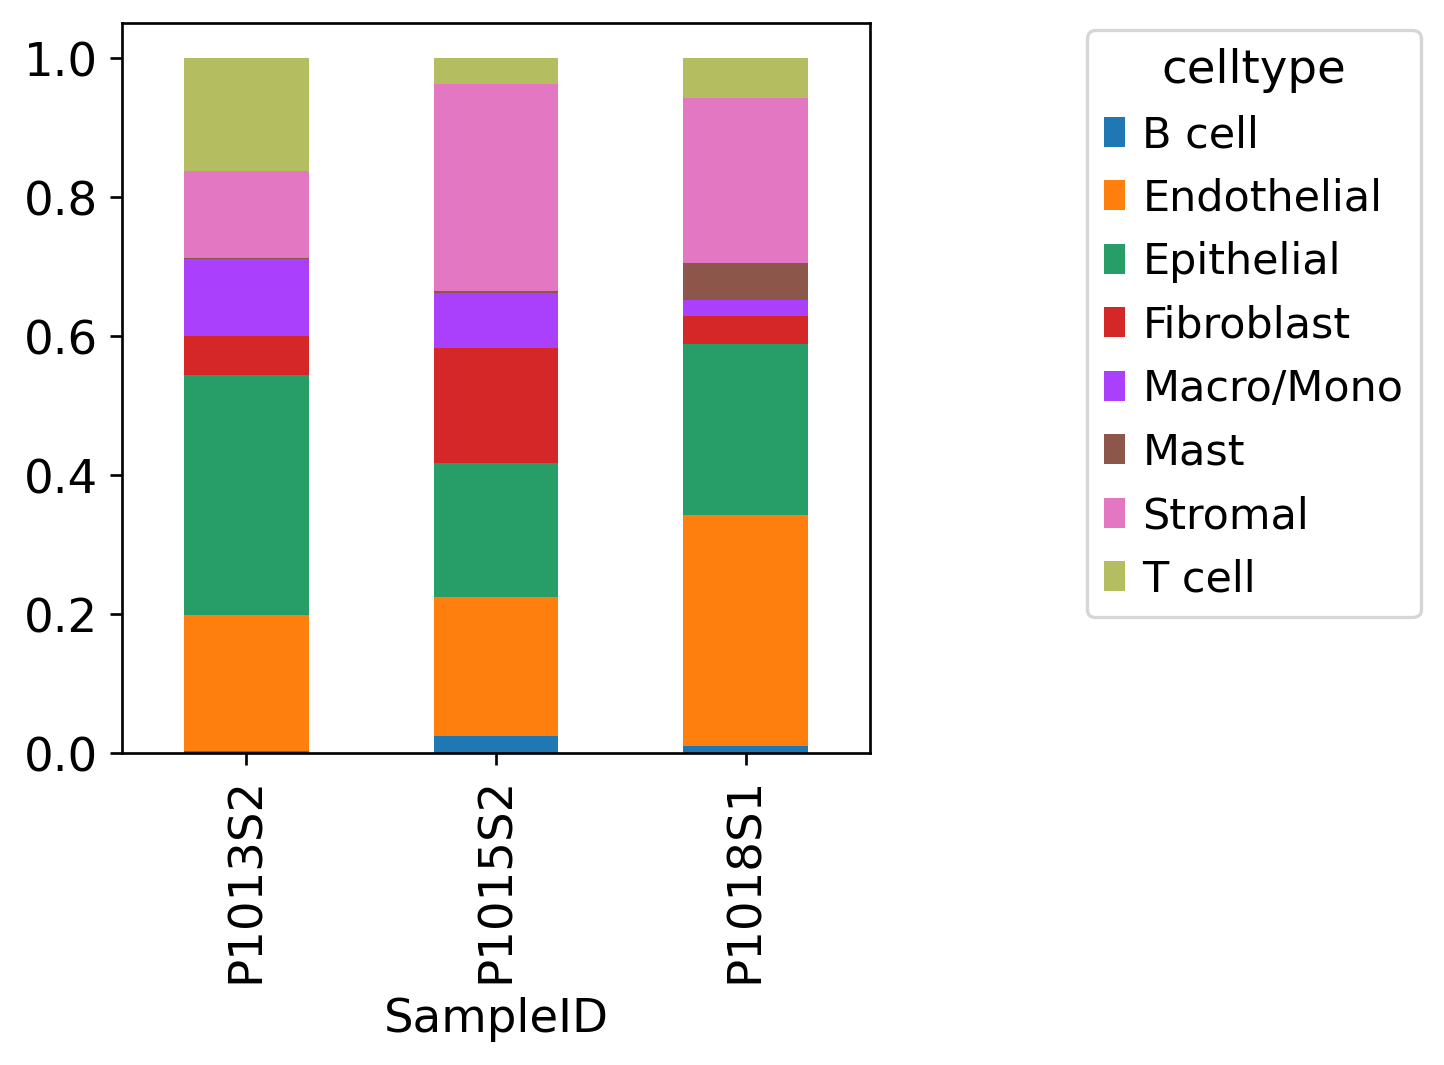

In [156]:
tmp = pd.crosstab(readata.obs['manual_celltype_annotation'],readata.obs['SampleID'], normalize='columns').T.plot(kind='bar', stacked=True,figsize = (4,4))
plt.grid(False)
tmp.legend(title='celltype', bbox_to_anchor=(1.26, 1.02),loc='best',)

In [ ]:
sc.pl.umap(adata, color=["manual_celltype_annotation", "SampleTimepoint"], frameon=False, ncols=2)

In [ ]:
# stackbarplot.R
# swarmplot.R

### 2.2 Tumor cell

#### 2.2.1 cNMF expression meta-program

In [ ]:
# cNMF.sh
# meta-program.R

#### 2.2.2 UPhyloplot2 evolutionary based on CNV

In [ ]:
# uphyloplot2
# python /home/zhepan/Software/uphyloplot2/uphyloplot2.py

### 2.3 Cell communication

#### 2.3.1 CellChat

In [ ]:
# cellchat.R

#### 2.3.2 Cellphonedb

#### 2.3.3 Nichenet

### 2.4 Trajectory

#### 2.4.1 cellrank based on scVelo

In [ ]:
# cellrank.ipynb

#### 2.4.2 Monocle

In [ ]:
# monocle3.R

#### 2.4.3 Slingshot

In [ ]:
# slingshot.R

#### 2.4.4 Diffuse


In [ ]:
# destiny.R

In [ ]:
sc.tl.diffmap(adata)
sc.pl.diffmap(adata, color='celltype')

#### 2.4.5 cytotrace

### 2.5 TF

#### 2.5.1 pySCENIC

In [ ]:
# pyscenic.sh

### 2.6 Metabolism

#### 2.6.1 pathway score

In [ ]:
# enrichment.R

#### 2.6.2 Compass

In [ ]:
# compass.sh

### 2.7 Mulitmodal including ATAC and spatial

### 2.8 Immune receptor repertoire


#### 2.8.1 CoNGA

In [ ]:
# conga.ipynb

#### 2.8.2 scRepertoire

In [ ]:
# ImmuneRep.R

### 2.9 Bulk deconvolution

### 2.10 GWAS

#### 2.10.1 sc-linker

In [ ]:
# ref: Identifying disease-critical cell types and cellular processes by integrating single-cell RNA-sequencing and human genetics

#### 2.10.2 scDRS